## 역세권 피처 추가

In [4]:
#강제 새로고침
import importlib
import base_model_utils
importlib.reload(base_model_utils)
from base_model_utils import set_korean_font, preprocess_base_df, train_compare_models, plot_dealamount_correlation, clean_numeric_df


In [66]:
# df_cleaned = preprocess_base_df(df)
# model = train_and_compare_models(df, features = ['excluUseAr', 'floor', 'buildingAge', 'deal_quarter', 'umdNm',
#             'is_high_floor', 'subway_distance', 'isStationNearby'])
# train_and_compare_models(df_cleaned, features)

In [5]:
set_korean_font()

In [6]:
import pandas as pd
base_model_df = pd.read_csv('01_base_model_df.csv')
df_cleaned = preprocess_base_df(base_model_df)
df = df_cleaned.copy()

In [7]:
df.head(3)

,aptDong,aptNm,buildYear,buyerGbn,cdealDay,cdealType,dealAmount,dealDay,dealMonth,dealYear,...,jibun,landLeaseholdGbn,rgstDate,sggCd,slerGbn,umdNm,buildingAge,isHighFloor,dealYearMonth,dealQuarter
0,306,우장산롯데캐슬,2003,개인,,,110000,29,3,2025,...,1145,N,25.07.01,11500,개인,화곡동,22,0,2025-03,1
1,,청솔102동,1997,개인,,,56991,17,3,2025,...,673-14,N,25.07.01,11500,개인,내발산동,28,0,2025-03,1
2,,강변,1992,개인,,,73000,29,3,2025,...,1475,N,,11500,개인,가양동,33,0,2025-03,1


In [23]:
# estateAgentSggNm에서 첫 번째 주소만 사용하도록 정제
df['estateAgentSggNmClean'] = df['estateAgentSggNm'].str.split(',').str[0]
df['aptAddress'] = df['estateAgentSggNmClean'] + ' ' + df['umdNm'] + ' ' + df['jibun'].astype(str)
df['aptAddress']

0       서울 강서구 화곡동 1145
1           내발산동 673-14
2       서울 강서구 가양동 1475
3      서울 강서구 마곡동 743-4
4       서울 강서구 내발산동 753
             ...       
456    서울 강서구 등촌동 634-2
457    서울 강서구 화곡동 926-5
458      서울 강서구 등촌동 688
459     서울 강서구 가양동 1475
460     서울 강서구 마곡동 1360
Name: aptAddress, Length: 461, dtype: object

In [24]:
df.isna().sum()

aptDong                    0
aptNm                      0
buildYear                  0
buyerGbn                   0
cdealDay                   0
cdealType                  0
dealAmount                 0
dealDay                    0
dealMonth                  0
dealYear                   0
dealingGbn                 0
estateAgentSggNm           0
excluUseAr                 0
floor                      0
jibun                      0
landLeaseholdGbn           0
rgstDate                   0
sggCd                      0
slerGbn                    0
umdNm                      0
buildingAge                0
isHighFloor                0
dealYearMonth              0
dealQuarter                0
estateAgentSggNmClean      0
aptAddress                 0
aptLat                   461
aptLng                   461
subwayDistance             0
isStationNearby            0
dtype: int64

In [25]:
df = df.dropna(subset=['aptLat', 'aptLng'])

In [57]:
import requests
import time
from dotenv import load_dotenv
import os
import pandas as pd
from tqdm import tqdm

# 1) 환경변수 로딩
load_dotenv()
KAKAO_API_KEY = os.getenv('KAKAO_API_KEY')
headers = {'Authorization': f'KakaoAK {KAKAO_API_KEY}'}

# 2) 주소 → 좌표 변환
def get_coords(address):
    url = 'https://dapi.kakao.com/v2/local/search/address.json'
    params = {'query': address}
    try:
        res = requests.get(url, headers=headers, params=params, timeout=10)
        res.raise_for_status()
        docs = res.json().get('documents', [])
        if not docs:
            return None
        coords = docs[0]['address']
        return float(coords['y']), float(coords['x'])  # (lat, lng)
    except Exception:
        return None

# 3) 지하철 검색 (가장 가까운 역만)
def get_nearby_subway(lat, lng):
    url = 'https://dapi.kakao.com/v2/local/search/category.json'
    params = {
        'category_group_code': 'SW8',
        'x': lng,
        'y': lat,
        'radius': 2500,
        'sort': 'distance'
    }
    try:
        res = requests.get(url, headers=headers, params=params, timeout=10)
        res.raise_for_status()
        return res.json().get('documents', [])
    except Exception:
        return []

# 4) 메인 루프
apt_lat, apt_lng = [], []
subway_distance_list = []
isStationNearby_list = []

for i, addr in tqdm(enumerate(df['aptAddress'].tolist()), total=len(df)):
    apt_name = df.iloc[i]['aptNm']
    coords = get_coords(addr)
    print(f'{i+1}. {apt_name} ({addr})')

    if coords:
        lat, lng = coords
        apt_lat.append(lat)
        apt_lng.append(lng)

        subways = get_nearby_subway(lat, lng)

        if subways:
            first = subways[0]  # 가장 가까운 역
            dist = int(first['distance'])
            name = first['place_name']
            subway_distance_list.append(dist)
            isStationNearby_list.append(dist <= 500)
            print(f"  가장 가까운 역: {name} ({dist}m)")
        else:
            subway_distance_list.append(2501)
            isStationNearby_list.append(False)
            print("  근처에 지하철역 없음")
    else:
        apt_lat.append(None)
        apt_lng.append(None)
        subway_distance_list.append(2501)
        isStationNearby_list.append(False)
        print("  주소 → 좌표 변환 실패")

    print("-" * 50)
    time.sleep(1)  # API rate limit 보호

out_path = 'apt_with_nearest_subway.csv'
df.to_csv(out_path, index=False, encoding='utf-8-sig')
print(f"✅ 저장 완료: {out_path}")


  0%|                                                   | 0/461 [00:00<?, ?it/s]

1. 우장산롯데캐슬 (서울 강서구 화곡동 1145)
  가장 가까운 역: 가양역 9호선 (839m)
--------------------------------------------------


  0%|                                           | 1/461 [00:01<09:19,  1.22s/it]

2. 청솔102동 (  내발산동 673-14)
  가장 가까운 역: 우장산역 5호선 (638m)
--------------------------------------------------


  0%|▏                                          | 2/461 [00:02<09:01,  1.18s/it]

3. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


  1%|▎                                          | 3/461 [00:03<08:54,  1.17s/it]

4. 마곡엠밸리7단지 (서울 강서구 마곡동 743-4)
  가장 가까운 역: 마곡나루역 공항철도 (373m)
--------------------------------------------------


  1%|▎                                          | 4/461 [00:04<08:52,  1.17s/it]

5. 마곡수명산파크4단지 (서울 강서구 내발산동 753)
  가장 가까운 역: 마곡역 5호선 (1005m)
--------------------------------------------------


  1%|▍                                          | 5/461 [00:05<08:49,  1.16s/it]

6. 등촌동아이파크 (서울 강서구 등촌동 715)
  가장 가까운 역: 등촌역 9호선 (904m)
--------------------------------------------------


  1%|▌                                          | 6/461 [00:06<08:47,  1.16s/it]

7. 강서쌍용예가 (서울 강서구 염창동 308)
  가장 가까운 역: 등촌역 9호선 (525m)
--------------------------------------------------


  2%|▋                                          | 7/461 [00:08<08:43,  1.15s/it]

8. 요산페어뷰 (서울 강서구 화곡동 377-21)
  가장 가까운 역: 화곡역 5호선 (655m)
--------------------------------------------------


  2%|▋                                          | 8/461 [00:09<08:42,  1.15s/it]

9. 신동아 (서울 강서구 염창동 289)
  가장 가까운 역: 등촌역 9호선 (577m)
--------------------------------------------------


  2%|▊                                          | 9/461 [00:10<08:41,  1.15s/it]

10. 주공3 (서울 강서구 등촌동 688)
  가장 가까운 역: 발산역 5호선 (443m)
--------------------------------------------------


  2%|▉                                         | 10/461 [00:11<08:43,  1.16s/it]

11. 마곡금호어울림 (서울 강서구 마곡동 717)
  가장 가까운 역: 양천향교역 9호선 (819m)
--------------------------------------------------


  2%|█                                         | 11/461 [00:12<08:41,  1.16s/it]

12. 강변한솔솔파크 (서울 강서구 염창동 300)
  가장 가까운 역: 증미역 9호선 (546m)
--------------------------------------------------


  3%|█                                         | 12/461 [00:13<08:37,  1.15s/it]

13. 스위트드림아파트 (서울 강서구 화곡동 1168)
  가장 가까운 역: 화곡역 5호선 (453m)
--------------------------------------------------


  3%|█▏                                        | 13/461 [00:15<08:34,  1.15s/it]

14. 요산페어뷰 (서울 강서구 화곡동 377-21)
  가장 가까운 역: 화곡역 5호선 (655m)
--------------------------------------------------


  3%|█▎                                        | 14/461 [00:16<08:31,  1.14s/it]

15. 마곡엠벨리(14단지) (서울 강서구 마곡동 750)
  가장 가까운 역: 마곡역 5호선 (376m)
--------------------------------------------------


  3%|█▎                                        | 15/461 [00:17<08:32,  1.15s/it]

16. 초록 (서울 강서구 화곡동 1139)
  가장 가까운 역: 우장산역 5호선 (421m)
--------------------------------------------------


  3%|█▍                                        | 16/461 [00:18<08:34,  1.16s/it]

17. 가양강나루현대 (서울 강서구 가양동 448-1)
  가장 가까운 역: 가양역 9호선 (237m)
--------------------------------------------------


  4%|█▌                                        | 17/461 [00:19<08:33,  1.16s/it]

18. 가양강나루현대 (서울 강서구 가양동 448-1)
  가장 가까운 역: 가양역 9호선 (237m)
--------------------------------------------------


  4%|█▋                                        | 18/461 [00:20<08:31,  1.15s/it]

19. 마곡엠밸리10단지 (서울 강서구 마곡동 747)
  가장 가까운 역: 마곡역 5호선 (485m)
--------------------------------------------------


  4%|█▋                                        | 19/461 [00:21<08:28,  1.15s/it]

20. 동성 (서울 강서구 방화동 817)
  가장 가까운 역: 방화역 5호선 (228m)
--------------------------------------------------


  4%|█▊                                        | 20/461 [00:23<08:31,  1.16s/it]

21. 태영 (  염창동 270-1)
  가장 가까운 역: 등촌역 9호선 (327m)
--------------------------------------------------


  5%|█▉                                        | 21/461 [00:24<08:27,  1.15s/it]

22. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


  5%|██                                        | 22/461 [00:25<08:25,  1.15s/it]

23. 신마곡벽산블루밍 (  방화동 904)
  가장 가까운 역: 개화산역 5호선 (183m)
--------------------------------------------------


  5%|██                                        | 23/461 [00:26<08:23,  1.15s/it]

24. 화곡1차보람더하임 (  화곡동 1087)
  가장 가까운 역: 화곡역 5호선 (605m)
--------------------------------------------------


  5%|██▏                                       | 24/461 [00:27<08:23,  1.15s/it]

25. NS파크APT (서울 강서구 화곡동 1076-9)
  가장 가까운 역: 화곡역 5호선 (133m)
--------------------------------------------------


  5%|██▎                                       | 25/461 [00:28<08:22,  1.15s/it]

26. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


  6%|██▎                                       | 26/461 [00:30<08:19,  1.15s/it]

27. 우장산롯데캐슬 (서울 강서구 화곡동 1145)
  가장 가까운 역: 가양역 9호선 (839m)
--------------------------------------------------


  6%|██▍                                       | 27/461 [00:31<08:17,  1.15s/it]

28. 빛고을우방 (서울 강서구 가양동 448-9)
  가장 가까운 역: 증미역 9호선 (323m)
--------------------------------------------------


  6%|██▌                                       | 28/461 [00:32<08:16,  1.15s/it]

29. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


  6%|██▋                                       | 29/461 [00:33<08:14,  1.15s/it]

30. 동아3 (서울 강서구 염창동 258-1)
  가장 가까운 역: 염창역 9호선 (422m)
--------------------------------------------------


  7%|██▋                                       | 30/461 [00:34<08:14,  1.15s/it]

31. 동아3 (서울 강서구 염창동 258-1)
  가장 가까운 역: 염창역 9호선 (422m)
--------------------------------------------------


  7%|██▊                                       | 31/461 [00:35<08:12,  1.14s/it]

32. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


  7%|██▉                                       | 32/461 [00:36<08:11,  1.15s/it]

33. 우장산타워빌 (서울 강서구 내발산동 704-2)
  가장 가까운 역: 우장산역 5호선 (389m)
--------------------------------------------------


  7%|███                                       | 33/461 [00:38<08:09,  1.14s/it]

34. 길성그랑프리텔 (서울 강서구 방화동 867)
  가장 가까운 역: 신방화역 9호선 (213m)
--------------------------------------------------


  7%|███                                       | 34/461 [00:39<08:10,  1.15s/it]

35. 삼정그린코아 (서울 강서구 염창동 282)
  가장 가까운 역: 염창역 9호선 (110m)
--------------------------------------------------


  8%|███▏                                      | 35/461 [00:40<08:14,  1.16s/it]

36. 세한(410-150) (서울 강서구 화곡동 410-150)
  가장 가까운 역: 까치산역 5호선 (738m)
--------------------------------------------------


  8%|███▎                                      | 36/461 [00:41<08:11,  1.16s/it]

37. 마곡에이치밸리움 (서울 강서구 내발산동 764)
  가장 가까운 역: 발산역 5호선 (585m)
--------------------------------------------------


  8%|███▎                                      | 37/461 [00:42<08:08,  1.15s/it]

38. 삼성하나로 (서울 강서구 염창동 248-3)
  가장 가까운 역: 등촌역 9호선 (568m)
--------------------------------------------------


  8%|███▍                                      | 38/461 [00:43<08:04,  1.15s/it]

39. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


  8%|███▌                                      | 39/461 [00:44<08:09,  1.16s/it]

40. 무학 (서울 강서구 염창동 255)
  가장 가까운 역: 염창역 9호선 (511m)
--------------------------------------------------


  9%|███▋                                      | 40/461 [00:46<08:07,  1.16s/it]

41. 가양2단지(성지) (경기 남양주시 가양동 1461)
  주소 → 좌표 변환 실패
--------------------------------------------------


  9%|███▋                                      | 41/461 [00:47<07:56,  1.13s/it]

42. 성재센트리움아파트(343-35) (  화곡동 343-35)
  가장 가까운 역: 까치산역 2호선 (80m)
--------------------------------------------------


  9%|███▊                                      | 42/461 [00:48<08:00,  1.15s/it]

43. 우장산롯데 (서울 강서구 화곡동 1148)
  가장 가까운 역: 우장산역 5호선 (984m)
--------------------------------------------------


  9%|███▉                                      | 43/461 [00:49<08:01,  1.15s/it]

44. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 10%|████                                      | 44/461 [00:50<07:59,  1.15s/it]

45. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 10%|████                                      | 45/461 [00:51<07:59,  1.15s/it]

46. 강변한솔솔파크 (서울 강서구 염창동 300)
  가장 가까운 역: 증미역 9호선 (546m)
--------------------------------------------------


 10%|████▏                                     | 46/461 [00:53<07:56,  1.15s/it]

47. 등촌7,8단지주공아파트 (서울 강서구 등촌동 707)
  가장 가까운 역: 가양역 9호선 (251m)
--------------------------------------------------


 10%|████▎                                     | 47/461 [00:54<07:53,  1.14s/it]

48. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


 10%|████▎                                     | 48/461 [00:55<07:58,  1.16s/it]

49. 등촌동아이파크 (서울 강서구 등촌동 715)
  가장 가까운 역: 등촌역 9호선 (904m)
--------------------------------------------------


 11%|████▍                                     | 49/461 [00:56<08:00,  1.17s/it]

50. 무학 (서울 강서구 염창동 255)
  가장 가까운 역: 염창역 9호선 (511m)
--------------------------------------------------


 11%|████▌                                     | 50/461 [00:57<07:56,  1.16s/it]

51. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 11%|████▋                                     | 51/461 [00:58<07:53,  1.16s/it]

52. 마곡엠벨리(14단지) (서울 강서구 마곡동 750)
  가장 가까운 역: 마곡역 5호선 (376m)
--------------------------------------------------


 11%|████▋                                     | 52/461 [00:59<07:53,  1.16s/it]

53. 빛고을우방 (서울 강서구 가양동 448-9)
  가장 가까운 역: 증미역 9호선 (323m)
--------------------------------------------------


 11%|████▊                                     | 53/461 [01:01<07:50,  1.15s/it]

54. 마곡중앙하이츠아파트 (서울 강서구 방화동 852)
  가장 가까운 역: 개화산역 5호선 (303m)
--------------------------------------------------


 12%|████▉                                     | 54/461 [01:02<07:50,  1.16s/it]

55. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


 12%|█████                                     | 55/461 [01:03<07:46,  1.15s/it]

56. 방화3차우림필유 (서울 강서구 방화동 546-1)
  가장 가까운 역: 개화산역 5호선 (488m)
--------------------------------------------------


 12%|█████                                     | 56/461 [01:04<07:48,  1.16s/it]

57. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 12%|█████▏                                    | 57/461 [01:05<07:53,  1.17s/it]

58. 염창동한강우성 (서울 강서구 염창동 66-9)
  가장 가까운 역: 등촌역 9호선 (693m)
--------------------------------------------------


 13%|█████▎                                    | 58/461 [01:06<07:50,  1.17s/it]

59. 화곡푸르지오 (서울 강서구 화곡동 1091)
  가장 가까운 역: 우장산역 5호선 (634m)
--------------------------------------------------


 13%|█████▍                                    | 59/461 [01:08<07:47,  1.16s/it]

60. 관음삼성 (서울 강서구 염창동 268)
  가장 가까운 역: 등촌역 9호선 (376m)
--------------------------------------------------


 13%|█████▍                                    | 60/461 [01:09<07:42,  1.15s/it]

61. 삼성하나로 (서울 강서구 염창동 248-3)
  가장 가까운 역: 등촌역 9호선 (568m)
--------------------------------------------------


 13%|█████▌                                    | 61/461 [01:10<07:40,  1.15s/it]

62. 주공3 (서울 강서구 등촌동 688)
  가장 가까운 역: 발산역 5호선 (443m)
--------------------------------------------------


 13%|█████▋                                    | 62/461 [01:11<07:37,  1.15s/it]

63. 가양강나루현대 (서울 강서구 가양동 448-1)
  가장 가까운 역: 가양역 9호선 (237m)
--------------------------------------------------


 14%|█████▋                                    | 63/461 [01:12<07:34,  1.14s/it]

64. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


 14%|█████▊                                    | 64/461 [01:13<07:33,  1.14s/it]

65. 현대1 (서울 강서구 염창동 288)
  가장 가까운 역: 염창역 9호선 (651m)
--------------------------------------------------


 14%|█████▉                                    | 65/461 [01:14<07:33,  1.15s/it]

66. 청솔 (서울 강서구 방화동 832)
  가장 가까운 역: 방화역 5호선 (219m)
--------------------------------------------------


 14%|██████                                    | 66/461 [01:16<07:33,  1.15s/it]

67. 한진로즈힐 (서울 강서구 방화동 579)
  가장 가까운 역: 신방화역 9호선 (565m)
--------------------------------------------------


 15%|██████                                    | 67/461 [01:17<07:31,  1.15s/it]

68. 염창3차보람 (서울 강서구 염창동 301)
  가장 가까운 역: 염창역 9호선 (660m)
--------------------------------------------------


 15%|██████▏                                   | 68/461 [01:18<07:41,  1.17s/it]

69. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


 15%|██████▎                                   | 69/461 [01:19<07:38,  1.17s/it]

70. 부영 (서울 강서구 등촌동 691-3)
  가장 가까운 역: 양천향교역 9호선 (523m)
--------------------------------------------------


 15%|██████▍                                   | 70/461 [01:20<07:36,  1.17s/it]

71. 강변한솔솔파크 (서울 강서구 염창동 300)
  가장 가까운 역: 증미역 9호선 (546m)
--------------------------------------------------


 15%|██████▍                                   | 71/461 [01:21<07:37,  1.17s/it]

72. 장미 (서울 강서구 방화동 841)
  가장 가까운 역: 방화역 5호선 (552m)
--------------------------------------------------


 16%|██████▌                                   | 72/461 [01:23<07:38,  1.18s/it]

73. 방화그린 (서울 강서구 방화동 839)
  가장 가까운 역: 방화역 5호선 (626m)
--------------------------------------------------


 16%|██████▋                                   | 73/461 [01:24<08:00,  1.24s/it]

74. 강서쌍용예가 (서울 강서구 염창동 308)
  가장 가까운 역: 등촌역 9호선 (525m)
--------------------------------------------------


 16%|██████▋                                   | 74/461 [01:25<07:58,  1.24s/it]

75. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


 16%|██████▊                                   | 75/461 [01:26<07:52,  1.22s/it]

76. 마곡서광(치현마을) (서울 강서구 방화동 860)
  가장 가까운 역: 방화역 5호선 (602m)
--------------------------------------------------


 16%|██████▉                                   | 76/461 [01:28<07:44,  1.21s/it]

77. 이너스내안에 (서울 강서구 염창동 254-2)
  가장 가까운 역: 염창역 9호선 (437m)
--------------------------------------------------


 17%|███████                                   | 77/461 [01:29<07:35,  1.19s/it]

78. 방신서광 (서울 강서구 방화동 871)
  가장 가까운 역: 개화산역 5호선 (346m)
--------------------------------------------------


 17%|███████                                   | 78/461 [01:30<07:29,  1.17s/it]

79. 가양우성 (서울 강서구 가양동 14-3)
  가장 가까운 역: 가양역 9호선 (90m)
--------------------------------------------------


 17%|███████▏                                  | 79/461 [01:31<07:26,  1.17s/it]

80. 주공5 (서울 강서구 등촌동 695)
  가장 가까운 역: 발산역 5호선 (660m)
--------------------------------------------------


 17%|███████▎                                  | 80/461 [01:32<07:22,  1.16s/it]

81. 가양우성 (서울 강서구 가양동 14-3)
  가장 가까운 역: 가양역 9호선 (90m)
--------------------------------------------------


 18%|███████▍                                  | 81/461 [01:33<07:28,  1.18s/it]

82. 신송타워 (서울 강서구 등촌동 662-3)
  가장 가까운 역: 가양역 9호선 (670m)
--------------------------------------------------


 18%|███████▍                                  | 82/461 [01:35<07:26,  1.18s/it]

83. 동성 (서울 강서구 방화동 817)
  가장 가까운 역: 방화역 5호선 (228m)
--------------------------------------------------


 18%|███████▌                                  | 83/461 [01:36<07:30,  1.19s/it]

84. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 18%|███████▋                                  | 84/461 [01:37<07:27,  1.19s/it]

85. 부영 (서울 강서구 등촌동 691-3)
  가장 가까운 역: 양천향교역 9호선 (523m)
--------------------------------------------------


 18%|███████▋                                  | 85/461 [01:38<07:30,  1.20s/it]

86. 스위트드림아파트 (서울 강서구 화곡동 1168)
  가장 가까운 역: 화곡역 5호선 (453m)
--------------------------------------------------


 19%|███████▊                                  | 86/461 [01:39<07:32,  1.21s/it]

87. 벽산 (서울 강서구 마곡동 429)
  가장 가까운 역: 양천향교역 9호선 (924m)
--------------------------------------------------


 19%|███████▉                                  | 87/461 [01:41<07:24,  1.19s/it]

88. 성재센트리움아파트 (서울 강서구 화곡동 143-11)
  가장 가까운 역: 화곡역 5호선 (132m)
--------------------------------------------------


 19%|████████                                  | 88/461 [01:42<07:23,  1.19s/it]

89. 방화5 (서울 강서구 방화동 814)
  가장 가까운 역: 방화역 5호선 (231m)
--------------------------------------------------


 19%|████████                                  | 89/461 [01:43<07:27,  1.20s/it]

90. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


 20%|████████▏                                 | 90/461 [01:44<07:26,  1.20s/it]

91. 화곡푸르지오 (서울 양천구 화곡동 1091)
  주소 → 좌표 변환 실패
--------------------------------------------------


 20%|████████▎                                 | 91/461 [01:45<07:11,  1.17s/it]

92. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 20%|████████▍                                 | 92/461 [01:47<07:13,  1.18s/it]

93. 서부인터빌아파트 (서울 강서구 화곡동 1074-18)
  가장 가까운 역: 화곡역 5호선 (116m)
--------------------------------------------------


 20%|████████▍                                 | 93/461 [01:48<07:09,  1.17s/it]

94. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 20%|████████▌                                 | 94/461 [01:49<07:05,  1.16s/it]

95. 마곡엠밸리7단지 (서울 강서구 마곡동 743-4)
  가장 가까운 역: 마곡나루역 공항철도 (373m)
--------------------------------------------------


 21%|████████▋                                 | 95/461 [01:50<07:03,  1.16s/it]

96. 방화5 (서울 강서구 방화동 814)
  가장 가까운 역: 방화역 5호선 (231m)
--------------------------------------------------


 21%|████████▋                                 | 96/461 [01:51<07:03,  1.16s/it]

97. 동성 (서울 강서구 방화동 817)
  가장 가까운 역: 방화역 5호선 (228m)
--------------------------------------------------


 21%|████████▊                                 | 97/461 [01:52<06:59,  1.15s/it]

98. 가양강나루현대 (서울 강서구 가양동 448-1)
  가장 가까운 역: 가양역 9호선 (237m)
--------------------------------------------------


 21%|████████▉                                 | 98/461 [01:53<06:57,  1.15s/it]

99. 태승훼미리아파트5차 (서울 강서구 내발산동 714-4)
  가장 가까운 역: 우장산역 5호선 (323m)
--------------------------------------------------


 21%|█████████                                 | 99/461 [01:55<06:56,  1.15s/it]

100. 청솔 (서울 강서구 방화동 832)
  가장 가까운 역: 방화역 5호선 (219m)
--------------------------------------------------


 22%|████████▉                                | 100/461 [01:56<06:55,  1.15s/it]

101. 성원 (서울 강서구 염창동 295)
  가장 가까운 역: 등촌역 9호선 (788m)
--------------------------------------------------


 22%|████████▉                                | 101/461 [01:57<06:55,  1.15s/it]

102. 동아 (서울 강서구 염창동 292)
  가장 가까운 역: 등촌역 9호선 (808m)
--------------------------------------------------


 22%|█████████                                | 102/461 [01:58<06:58,  1.17s/it]

103. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


 22%|█████████▏                               | 103/461 [01:59<07:02,  1.18s/it]

104. 동부센트레빌 (서울 강서구 방화동 870)
  가장 가까운 역: 개화산역 5호선 (102m)
--------------------------------------------------


 23%|█████████▏                               | 104/461 [02:01<07:06,  1.20s/it]

105. 마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748)
  가장 가까운 역: 마곡역 5호선 (627m)
--------------------------------------------------


 23%|█████████▎                               | 105/461 [02:02<07:07,  1.20s/it]

106. 부영 (부산 부산진구 등촌동 691-3)
  주소 → 좌표 변환 실패
--------------------------------------------------


 23%|█████████▍                               | 106/461 [02:03<06:58,  1.18s/it]

107. 마곡엠밸리5단지 (서울 강서구 마곡동 740)
  가장 가까운 역: 신방화역 9호선 (190m)
--------------------------------------------------


 23%|█████████▌                               | 107/461 [02:04<06:54,  1.17s/it]

108. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 23%|█████████▌                               | 108/461 [02:05<06:51,  1.17s/it]

109. 강서월드메르디앙 (서울 강서구 내발산동 659-1)
  가장 가까운 역: 발산역 5호선 (507m)
--------------------------------------------------


 24%|█████████▋                               | 109/461 [02:06<06:47,  1.16s/it]

110. 삼정그린코아 (서울 강서구 염창동 282)
  가장 가까운 역: 염창역 9호선 (110m)
--------------------------------------------------


 24%|█████████▊                               | 110/461 [02:07<06:45,  1.16s/it]

111. 서광등촌마을아파트 (서울 강서구 등촌동 638)
  가장 가까운 역: 증미역 9호선 (283m)
--------------------------------------------------


 24%|█████████▊                               | 111/461 [02:09<06:44,  1.15s/it]

112. 동아3 (서울 강서구 염창동 258-1)
  가장 가까운 역: 염창역 9호선 (422m)
--------------------------------------------------


 24%|█████████▉                               | 112/461 [02:10<06:42,  1.15s/it]

113. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 25%|██████████                               | 113/461 [02:11<06:40,  1.15s/it]

114. 마곡수명산파크4단지 (서울 강서구 내발산동 753)
  가장 가까운 역: 마곡역 5호선 (1005m)
--------------------------------------------------


 25%|██████████▏                              | 114/461 [02:12<06:37,  1.14s/it]

115. 요산페어뷰 (서울 강서구 화곡동 377-21)
  가장 가까운 역: 화곡역 5호선 (655m)
--------------------------------------------------


 25%|██████████▏                              | 115/461 [02:13<06:36,  1.15s/it]

116. 강변한솔솔파크 (서울 강서구 염창동 300)
  가장 가까운 역: 증미역 9호선 (546m)
--------------------------------------------------


 25%|██████████▎                              | 116/461 [02:14<06:35,  1.15s/it]

117. 우장산힐스테이트 (서울 강서구 내발산동 657)
  가장 가까운 역: 발산역 5호선 (285m)
--------------------------------------------------


 25%|██████████▍                              | 117/461 [02:15<06:34,  1.15s/it]

118. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 26%|██████████▍                              | 118/461 [02:17<06:32,  1.14s/it]

119. 마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748)
  가장 가까운 역: 마곡역 5호선 (627m)
--------------------------------------------------


 26%|██████████▌                              | 119/461 [02:18<06:35,  1.16s/it]

120. 삼성한아름 (서울 강서구 염창동 264-27)
  가장 가까운 역: 염창역 9호선 (447m)
--------------------------------------------------


 26%|██████████▋                              | 120/461 [02:19<06:32,  1.15s/it]

121. 마곡중앙하이츠아파트 (서울 강서구 방화동 852)
  가장 가까운 역: 개화산역 5호선 (303m)
--------------------------------------------------


 26%|██████████▊                              | 121/461 [02:20<06:44,  1.19s/it]

122. 등촌7,8단지주공아파트 (서울 강서구 등촌동 707)
  가장 가까운 역: 가양역 9호선 (251m)
--------------------------------------------------


 26%|██████████▊                              | 122/461 [02:21<06:38,  1.18s/it]

123. 동아3 (서울 강서구 염창동 258-1)
  가장 가까운 역: 염창역 9호선 (422m)
--------------------------------------------------


 27%|██████████▉                              | 123/461 [02:23<06:33,  1.16s/it]

124. 마곡엠밸리8단지 (서울 강서구 마곡동 741)
  가장 가까운 역: 신방화역 9호선 (444m)
--------------------------------------------------


 27%|███████████                              | 124/461 [02:24<06:30,  1.16s/it]

125. 태영 (서울 강서구 등촌동 632-2)
  가장 가까운 역: 증미역 9호선 (407m)
--------------------------------------------------


 27%|███████████                              | 125/461 [02:25<06:28,  1.16s/it]

126. 남광아파트 (서울 강서구 화곡동 920-15)
  가장 가까운 역: 까치산역 5호선 (494m)
--------------------------------------------------


 27%|███████████▏                             | 126/461 [02:26<06:26,  1.15s/it]

127. 미주 (서울 강서구 화곡동 474-1)
  가장 가까운 역: 까치산역 5호선 (972m)
--------------------------------------------------


 28%|███████████▎                             | 127/461 [02:27<06:30,  1.17s/it]

128. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 28%|███████████▍                             | 128/461 [02:28<06:29,  1.17s/it]

129. 주공3 (서울 강서구 등촌동 688)
  가장 가까운 역: 발산역 5호선 (443m)
--------------------------------------------------


 28%|███████████▍                             | 129/461 [02:29<06:26,  1.16s/it]

130. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 28%|███████████▌                             | 130/461 [02:31<06:24,  1.16s/it]

131. 강서센트레빌3차(894-0) (  방화동 894)
  가장 가까운 역: 신방화역 9호선 (428m)
--------------------------------------------------


 28%|███████████▋                             | 131/461 [02:32<06:21,  1.16s/it]

132. 주공10 (서울 강서구 등촌동 702)
  가장 가까운 역: 가양역 9호선 (544m)
--------------------------------------------------


 29%|███████████▋                             | 132/461 [02:33<06:19,  1.15s/it]

133. 롯데2 (서울 강서구 내발산동 729)
  가장 가까운 역: 발산역 5호선 (628m)
--------------------------------------------------


 29%|███████████▊                             | 133/461 [02:34<06:19,  1.16s/it]

134. 마곡중앙하이츠아파트 (서울 강서구 방화동 852)
  가장 가까운 역: 개화산역 5호선 (303m)
--------------------------------------------------


 29%|███████████▉                             | 134/461 [02:35<06:16,  1.15s/it]

135. 극동상록수 (서울 강서구 염창동 280)
  가장 가까운 역: 염창역 9호선 (325m)
--------------------------------------------------


 29%|████████████                             | 135/461 [02:36<06:14,  1.15s/it]

136. 동부센트레빌 (서울 강서구 방화동 870)
  가장 가까운 역: 개화산역 5호선 (102m)
--------------------------------------------------


 30%|████████████                             | 136/461 [02:38<06:12,  1.15s/it]

137. 극동 (서울 강서구 염창동 246-23)
  가장 가까운 역: 등촌역 9호선 (557m)
--------------------------------------------------


 30%|████████████▏                            | 137/461 [02:39<06:15,  1.16s/it]

138. 방화5 (서울 강서구 방화동 814)
  가장 가까운 역: 방화역 5호선 (231m)
--------------------------------------------------


 30%|████████████▎                            | 138/461 [02:40<06:12,  1.15s/it]

139. 주공3 (서울 강서구 등촌동 688)
  가장 가까운 역: 발산역 5호선 (443m)
--------------------------------------------------


 30%|████████████▎                            | 139/461 [02:41<06:09,  1.15s/it]

140. 마곡수명산파크3단지 (서울 강서구 내발산동 751)
  가장 가까운 역: 마곡역 5호선 (822m)
--------------------------------------------------


 30%|████████████▍                            | 140/461 [02:42<06:14,  1.17s/it]

141. 청솔 (서울 강서구 방화동 832)
  가장 가까운 역: 방화역 5호선 (219m)
--------------------------------------------------


 31%|████████████▌                            | 141/461 [02:43<06:11,  1.16s/it]

142. 방신서광 (서울 강서구 방화동 871)
  가장 가까운 역: 개화산역 5호선 (346m)
--------------------------------------------------


 31%|████████████▋                            | 142/461 [02:44<06:07,  1.15s/it]

143. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 31%|████████████▋                            | 143/461 [02:46<06:04,  1.15s/it]

144. 마곡힐스테이트 (서울 강서구 마곡동 725-1)
  가장 가까운 역: 신방화역 9호선 (387m)
--------------------------------------------------


 31%|████████████▊                            | 144/461 [02:47<06:04,  1.15s/it]

145. 현대 (서울 강서구 등촌동 655-27)
  가장 가까운 역: 증미역 9호선 (531m)
--------------------------------------------------


 31%|████████████▉                            | 145/461 [02:48<06:02,  1.15s/it]

146. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 32%|████████████▉                            | 146/461 [02:49<06:01,  1.15s/it]

147. 초록 (서울 강서구 화곡동 1139)
  가장 가까운 역: 우장산역 5호선 (421m)
--------------------------------------------------


 32%|█████████████                            | 147/461 [02:50<06:01,  1.15s/it]

148. 주공5 (  등촌동 695)
  가장 가까운 역: 발산역 5호선 (660m)
--------------------------------------------------


 32%|█████████████▏                           | 148/461 [02:51<05:58,  1.15s/it]

149. 강서한강월드메르디앙 (서울 강서구 가양동 1462)
  가장 가까운 역: 양천향교역 9호선 (268m)
--------------------------------------------------


 32%|█████████████▎                           | 149/461 [02:53<05:58,  1.15s/it]

150. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 33%|█████████████▎                           | 150/461 [02:54<06:02,  1.16s/it]

151. 방화그린 (서울 강서구 방화동 839)
  가장 가까운 역: 방화역 5호선 (626m)
--------------------------------------------------


 33%|█████████████▍                           | 151/461 [02:55<05:58,  1.16s/it]

152. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 33%|█████████████▌                           | 152/461 [02:56<05:58,  1.16s/it]

153. 극동상록수 (서울 강서구 염창동 280)
  가장 가까운 역: 염창역 9호선 (325m)
--------------------------------------------------


 33%|█████████████▌                           | 153/461 [02:57<05:53,  1.15s/it]

154. 드림시드아파트1차 (서울 강서구 화곡동 899-13)
  가장 가까운 역: 까치산역 2호선 (161m)
--------------------------------------------------


 33%|█████████████▋                           | 154/461 [02:58<05:52,  1.15s/it]

155. 신안 (서울 강서구 마곡동 422)
  가장 가까운 역: 마곡나루역 9호선 (424m)
--------------------------------------------------


 34%|█████████████▊                           | 155/461 [02:59<05:51,  1.15s/it]

156. 우장산롯데캐슬 (서울 강서구 화곡동 1145)
  가장 가까운 역: 가양역 9호선 (839m)
--------------------------------------------------


 34%|█████████████▊                           | 156/461 [03:01<05:51,  1.15s/it]

157. 동신대아 (서울 강서구 가양동 1459)
  가장 가까운 역: 양천향교역 9호선 (470m)
--------------------------------------------------


 34%|█████████████▉                           | 157/461 [03:02<05:48,  1.15s/it]

158. 마곡서광(치현마을) (서울 강서구 방화동 860)
  가장 가까운 역: 방화역 5호선 (602m)
--------------------------------------------------


 34%|██████████████                           | 158/461 [03:03<05:46,  1.14s/it]

159. 마곡현대아파트 (경기 김포시 마곡동 1171)
  주소 → 좌표 변환 실패
--------------------------------------------------


 34%|██████████████▏                          | 159/461 [03:04<05:38,  1.12s/it]

160. 롯데캐슬 (서울 강서구 염창동 272-11)
  가장 가까운 역: 등촌역 9호선 (246m)
--------------------------------------------------


 35%|██████████████▏                          | 160/461 [03:05<05:40,  1.13s/it]

161. 우장산힐스테이트 (서울 강서구 내발산동 657)
  가장 가까운 역: 발산역 5호선 (285m)
--------------------------------------------------


 35%|██████████████▎                          | 161/461 [03:06<05:40,  1.13s/it]

162. 롯데캐슬 (서울 강서구 염창동 272-11)
  가장 가까운 역: 등촌역 9호선 (246m)
--------------------------------------------------


 35%|██████████████▍                          | 162/461 [03:07<05:39,  1.14s/it]

163. 마곡수명산파크5단지 (서울 강서구 내발산동 749)
  가장 가까운 역: 우장산역 5호선 (890m)
--------------------------------------------------


 35%|██████████████▍                          | 163/461 [03:09<05:39,  1.14s/it]

164. 가양도시개발9-2단지 (서울 강서구 가양동 1490)
  가장 가까운 역: 증미역 9호선 (264m)
--------------------------------------------------


 36%|██████████████▌                          | 164/461 [03:10<05:37,  1.14s/it]

165. 우장산힐스테이트 (서울 강서구 내발산동 657)
  가장 가까운 역: 발산역 5호선 (285m)
--------------------------------------------------


 36%|██████████████▋                          | 165/461 [03:11<05:36,  1.14s/it]

166. 서부인터빌아파트 (서울 강서구 화곡동 1074-18)
  가장 가까운 역: 화곡역 5호선 (116m)
--------------------------------------------------


 36%|██████████████▊                          | 166/461 [03:12<05:35,  1.14s/it]

167. 이너스내안에 (서울 강서구 염창동 254-2)
  가장 가까운 역: 염창역 9호선 (437m)
--------------------------------------------------


 36%|██████████████▊                          | 167/461 [03:13<05:34,  1.14s/it]

168. 마곡엠밸리6단지 (서울 강서구 마곡동 743)
  가장 가까운 역: 신방화역 9호선 (373m)
--------------------------------------------------


 36%|██████████████▉                          | 168/461 [03:14<05:34,  1.14s/it]

169. 동아 (서울 강서구 염창동 292)
  가장 가까운 역: 등촌역 9호선 (808m)
--------------------------------------------------


 37%|███████████████                          | 169/461 [03:15<05:32,  1.14s/it]

170. 대림경동아파트 (서울 강서구 가양동 1474)
  가장 가까운 역: 가양역 9호선 (546m)
--------------------------------------------------


 37%|███████████████                          | 170/461 [03:16<05:31,  1.14s/it]

171. 마곡중앙하이츠아파트 (경기 고양시 덕양구 방화동 852)
  주소 → 좌표 변환 실패
--------------------------------------------------


 37%|███████████████▏                         | 171/461 [03:18<05:25,  1.12s/it]

172. NS파크APT (서울 강서구 화곡동 1076-9)
  가장 가까운 역: 화곡역 5호선 (133m)
--------------------------------------------------


 37%|███████████████▎                         | 172/461 [03:19<05:43,  1.19s/it]

173. 우장산힐스테이트 (서울 강서구 내발산동 657)
  가장 가까운 역: 발산역 5호선 (285m)
--------------------------------------------------


 38%|███████████████▍                         | 173/461 [03:20<05:41,  1.19s/it]

174. 주공10 (서울 강서구 등촌동 702)
  가장 가까운 역: 가양역 9호선 (544m)
--------------------------------------------------


 38%|███████████████▍                         | 174/461 [03:21<05:44,  1.20s/it]

175. 마곡엠밸리8단지 (서울 강서구 마곡동 741)
  가장 가까운 역: 신방화역 9호선 (444m)
--------------------------------------------------


 38%|███████████████▌                         | 175/461 [03:23<05:54,  1.24s/it]

176. 강서월드메르디앙 (서울 강서구 내발산동 659-1)
  가장 가까운 역: 발산역 5호선 (507m)
--------------------------------------------------


 38%|███████████████▋                         | 176/461 [03:24<05:52,  1.24s/it]

177. 등촌7,8단지주공아파트 (서울 강서구 등촌동 707)
  가장 가까운 역: 가양역 9호선 (251m)
--------------------------------------------------


 38%|███████████████▋                         | 177/461 [03:25<05:50,  1.23s/it]

178. 한숲마을대림 (서울 강서구 방화동 862)
  가장 가까운 역: 방화역 5호선 (416m)
--------------------------------------------------


 39%|███████████████▊                         | 178/461 [03:26<05:45,  1.22s/it]

179. 마곡수명산파크4단지 (서울 강서구 내발산동 753)
  가장 가까운 역: 마곡역 5호선 (1005m)
--------------------------------------------------


 39%|███████████████▉                         | 179/461 [03:28<05:42,  1.21s/it]

180. 태청 (서울 강서구 방화동 319-9)
  가장 가까운 역: 방화역 5호선 (318m)
--------------------------------------------------


 39%|████████████████                         | 180/461 [03:29<05:38,  1.21s/it]

181. 등촌동아이파크 (서울 강서구 등촌동 715)
  가장 가까운 역: 등촌역 9호선 (904m)
--------------------------------------------------


 39%|████████████████                         | 181/461 [03:30<05:38,  1.21s/it]

182. 강서한강자이 (서울 강서구 가양동 1500)
  가장 가까운 역: 양천향교역 9호선 (657m)
--------------------------------------------------


 39%|████████████████▏                        | 182/461 [03:31<05:38,  1.21s/it]

183. 마곡중앙하이츠아파트 (서울 강서구 방화동 852)
  가장 가까운 역: 개화산역 5호선 (303m)
--------------------------------------------------


 40%|████████████████▎                        | 183/461 [03:32<05:37,  1.21s/it]

184. 주공10 (서울 강서구 등촌동 702)
  가장 가까운 역: 가양역 9호선 (544m)
--------------------------------------------------


 40%|████████████████▎                        | 184/461 [03:33<05:29,  1.19s/it]

185. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


 40%|████████████████▍                        | 185/461 [03:35<05:24,  1.17s/it]

186. 가양도시개발9-2단지 (서울 강서구 가양동 1490)
  가장 가까운 역: 증미역 9호선 (264m)
--------------------------------------------------


 40%|████████████████▌                        | 186/461 [03:36<05:18,  1.16s/it]

187. 방화그린 (서울 강서구 방화동 839)
  가장 가까운 역: 방화역 5호선 (626m)
--------------------------------------------------


 41%|████████████████▋                        | 187/461 [03:37<05:16,  1.16s/it]

188. 한강타운 (서울 강서구 가양동 1460)
  가장 가까운 역: 양천향교역 9호선 (453m)
--------------------------------------------------


 41%|████████████████▋                        | 188/461 [03:38<05:15,  1.15s/it]

189. 태영 (서울 강서구 염창동 270-1)
  가장 가까운 역: 등촌역 9호선 (327m)
--------------------------------------------------


 41%|████████████████▊                        | 189/461 [03:39<05:13,  1.15s/it]

190. 마곡수명산파크7단지 (서울 강서구 내발산동 756)
  가장 가까운 역: 우장산역 5호선 (1205m)
--------------------------------------------------


 41%|████████████████▉                        | 190/461 [03:40<05:11,  1.15s/it]

191. 대림e편한세상 (서울 강서구 화곡동 361-1)
  가장 가까운 역: 까치산역 5호선 (818m)
--------------------------------------------------


 41%|████████████████▉                        | 191/461 [03:41<05:11,  1.15s/it]

192. e편한세상염창 (서울 강서구 염창동 309)
  가장 가까운 역: 염창역 9호선 (422m)
--------------------------------------------------


 42%|█████████████████                        | 192/461 [03:43<05:10,  1.15s/it]

193. 마곡중앙하이츠아파트 (서울 강서구 방화동 852)
  가장 가까운 역: 개화산역 5호선 (303m)
--------------------------------------------------


 42%|█████████████████▏                       | 193/461 [03:44<05:07,  1.15s/it]

194. 태진아름 (서울 강서구 등촌동 676)
  가장 가까운 역: 등촌역 9호선 (473m)
--------------------------------------------------


 42%|█████████████████▎                       | 194/461 [03:45<05:05,  1.14s/it]

195. 마곡수명산파크3단지 (  내발산동 751)
  가장 가까운 역: 마곡역 5호선 (822m)
--------------------------------------------------


 42%|█████████████████▎                       | 195/461 [03:46<05:05,  1.15s/it]

196. 가양도시개발9-2단지 (서울 강서구 가양동 1490)
  가장 가까운 역: 증미역 9호선 (264m)
--------------------------------------------------


 43%|█████████████████▍                       | 196/461 [03:47<05:04,  1.15s/it]

197. 동아3 (서울 강서구 염창동 258-1)
  가장 가까운 역: 염창역 9호선 (422m)
--------------------------------------------------


 43%|█████████████████▌                       | 197/461 [03:48<05:02,  1.15s/it]

198. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 43%|█████████████████▌                       | 198/461 [03:50<05:00,  1.14s/it]

199. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


 43%|█████████████████▋                       | 199/461 [03:51<04:59,  1.14s/it]

200. 이너스내안에 (서울 강서구 염창동 254-2)
  가장 가까운 역: 염창역 9호선 (437m)
--------------------------------------------------


 43%|█████████████████▊                       | 200/461 [03:52<04:58,  1.14s/it]

201. 마곡금호어울림 (서울 강서구 마곡동 717)
  가장 가까운 역: 양천향교역 9호선 (819m)
--------------------------------------------------


 44%|█████████████████▉                       | 201/461 [03:53<04:57,  1.14s/it]

202. 이너스내안에 (서울 강서구 염창동 254-2)
  가장 가까운 역: 염창역 9호선 (437m)
--------------------------------------------------


 44%|█████████████████▉                       | 202/461 [03:54<04:56,  1.14s/it]

203. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 44%|██████████████████                       | 203/461 [03:55<04:54,  1.14s/it]

204. 우장산숲아이파크 (서울 강서구 화곡동 1173)
  가장 가까운 역: 화곡역 5호선 (380m)
--------------------------------------------------


 44%|██████████████████▏                      | 204/461 [03:56<04:54,  1.15s/it]

205. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


 44%|██████████████████▏                      | 205/461 [03:58<04:52,  1.14s/it]

206. 극동 (서울 강서구 염창동 246-23)
  가장 가까운 역: 등촌역 9호선 (557m)
--------------------------------------------------


 45%|██████████████████▎                      | 206/461 [03:59<04:52,  1.15s/it]

207. 위하우스아파트 (서울 강서구 화곡동 916-2)
  가장 가까운 역: 까치산역 2호선 (360m)
--------------------------------------------------


 45%|██████████████████▍                      | 207/461 [04:00<04:50,  1.14s/it]

208. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 45%|██████████████████▍                      | 208/461 [04:01<04:49,  1.14s/it]

209. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 45%|██████████████████▌                      | 209/461 [04:02<04:49,  1.15s/it]

210. 등촌라인(조합) (서울 강남구 등촌동 628-15)
  주소 → 좌표 변환 실패
--------------------------------------------------


 46%|██████████████████▋                      | 210/461 [04:03<04:45,  1.14s/it]

211. 마곡현대아파트 (경기 김포시 마곡동 1171)
  주소 → 좌표 변환 실패
--------------------------------------------------


 46%|██████████████████▊                      | 211/461 [04:04<04:38,  1.12s/it]

212. 마곡청구아파트 (서울 강서구 마곡동 1181)
  가장 가까운 역: 신방화역 9호선 (710m)
--------------------------------------------------


 46%|██████████████████▊                      | 212/461 [04:06<04:47,  1.16s/it]

213. 강서쌍용예가 (서울 강서구 염창동 308)
  가장 가까운 역: 등촌역 9호선 (525m)
--------------------------------------------------


 46%|██████████████████▉                      | 213/461 [04:07<04:54,  1.19s/it]

214. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 46%|███████████████████                      | 214/461 [04:08<04:49,  1.17s/it]

215. 강서한강자이 (서울 강서구 가양동 1500)
  가장 가까운 역: 양천향교역 9호선 (657m)
--------------------------------------------------


 47%|███████████████████                      | 215/461 [04:09<04:46,  1.16s/it]

216. 한강타운 (서울 강서구 가양동 1460)
  가장 가까운 역: 양천향교역 9호선 (453m)
--------------------------------------------------


 47%|███████████████████▏                     | 216/461 [04:10<04:43,  1.16s/it]

217. 주공10 (서울 강서구 등촌동 702)
  가장 가까운 역: 가양역 9호선 (544m)
--------------------------------------------------


 47%|███████████████████▎                     | 217/461 [04:11<04:41,  1.15s/it]

218. 마곡힐스테이트 (서울 강서구 마곡동 725-1)
  가장 가까운 역: 신방화역 9호선 (387m)
--------------------------------------------------


 47%|███████████████████▍                     | 218/461 [04:13<04:42,  1.16s/it]

219. 부영 (서울 강서구 등촌동 691-3)
  가장 가까운 역: 양천향교역 9호선 (523m)
--------------------------------------------------


 48%|███████████████████▍                     | 219/461 [04:14<04:42,  1.17s/it]

220. 마곡서광(치현마을) (서울 강서구 방화동 860)
  가장 가까운 역: 방화역 5호선 (602m)
--------------------------------------------------


 48%|███████████████████▌                     | 220/461 [04:15<04:40,  1.16s/it]

221. 마곡엠밸리4단지 (서울 강서구 마곡동 738)
  가장 가까운 역: 마곡나루역 9호선 (412m)
--------------------------------------------------


 48%|███████████████████▋                     | 221/461 [04:16<04:39,  1.16s/it]

222. 대림e-편한세상 (서울 강서구 방화동 874)
  가장 가까운 역: 개화산역 5호선 (296m)
--------------------------------------------------


 48%|███████████████████▋                     | 222/461 [04:17<04:37,  1.16s/it]

223. 성원 (서울 강서구 염창동 295)
  가장 가까운 역: 등촌역 9호선 (788m)
--------------------------------------------------


 48%|███████████████████▊                     | 223/461 [04:18<04:36,  1.16s/it]

224. 주공5 (  등촌동 695)
  가장 가까운 역: 발산역 5호선 (660m)
--------------------------------------------------


 49%|███████████████████▉                     | 224/461 [04:20<04:34,  1.16s/it]

225. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


 49%|████████████████████                     | 225/461 [04:21<04:34,  1.17s/it]

226. 우장산롯데캐슬 (서울 강서구 화곡동 1145)
  가장 가까운 역: 가양역 9호선 (839m)
--------------------------------------------------


 49%|████████████████████                     | 226/461 [04:22<04:32,  1.16s/it]

227. 성원 (서울 강서구 염창동 295)
  가장 가까운 역: 등촌역 9호선 (788m)
--------------------------------------------------


 49%|████████████████████▏                    | 227/461 [04:23<04:30,  1.16s/it]

228. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 49%|████████████████████▎                    | 228/461 [04:24<04:28,  1.15s/it]

229. 화곡푸르지오 (서울 강서구 화곡동 1091)
  가장 가까운 역: 우장산역 5호선 (634m)
--------------------------------------------------


 50%|████████████████████▎                    | 229/461 [04:25<04:29,  1.16s/it]

230. 강서힐스테이트 (경기 안양시 만안구 화곡동 1165)
  주소 → 좌표 변환 실패
--------------------------------------------------


 50%|████████████████████▍                    | 230/461 [04:26<04:21,  1.13s/it]

231. 마곡청구아파트 (서울 강서구 마곡동 1181)
  가장 가까운 역: 신방화역 9호선 (710m)
--------------------------------------------------


 50%|████████████████████▌                    | 231/461 [04:28<04:21,  1.14s/it]

232. 우장산힐스테이트 (서울 강서구 내발산동 657)
  가장 가까운 역: 발산역 5호선 (285m)
--------------------------------------------------


 50%|████████████████████▋                    | 232/461 [04:29<04:21,  1.14s/it]

233. 강서한강자이 (서울 강서구 가양동 1500)
  가장 가까운 역: 양천향교역 9호선 (657m)
--------------------------------------------------


 51%|████████████████████▋                    | 233/461 [04:30<04:20,  1.14s/it]

234. 한미(286-1) (서울 강서구 방화동 286-1)
  가장 가까운 역: 방화역 5호선 (466m)
--------------------------------------------------


 51%|████████████████████▊                    | 234/461 [04:31<04:19,  1.15s/it]

235. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 51%|████████████████████▉                    | 235/461 [04:32<04:18,  1.14s/it]

236. 화곡한강 (서울 강서구 화곡동 1059-19)
  가장 가까운 역: 화곡역 5호선 (408m)
--------------------------------------------------


 51%|████████████████████▉                    | 236/461 [04:33<04:17,  1.15s/it]

237. 유원펠리체(924-17) (서울 강서구 화곡동 924-17)
  가장 가까운 역: 까치산역 2호선 (534m)
--------------------------------------------------


 51%|█████████████████████                    | 237/461 [04:34<04:16,  1.14s/it]

238. 강서월드메르디앙 (서울 강서구 내발산동 659-1)
  가장 가까운 역: 발산역 5호선 (507m)
--------------------------------------------------


 52%|█████████████████████▏                   | 238/461 [04:36<04:14,  1.14s/it]

239. 강변힐스테이트 (서울 강서구 염창동 299)
  가장 가까운 역: 염창역 9호선 (474m)
--------------------------------------------------


 52%|█████████████████████▎                   | 239/461 [04:37<04:13,  1.14s/it]

240. 등촌1,2단지주공아파트 (서울 강서구 등촌동 687)
  가장 가까운 역: 양천향교역 9호선 (347m)
--------------------------------------------------


 52%|█████████████████████▎                   | 240/461 [04:38<04:13,  1.14s/it]

241. 화곡푸르지오 (서울 양천구 화곡동 1091)
  주소 → 좌표 변환 실패
--------------------------------------------------


 52%|█████████████████████▍                   | 241/461 [04:39<04:06,  1.12s/it]

242. 한강동아 (서울 강서구 염창동 293)
  가장 가까운 역: 염창역 9호선 (778m)
--------------------------------------------------


 52%|█████████████████████▌                   | 242/461 [04:40<04:07,  1.13s/it]

243. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 53%|█████████████████████▌                   | 243/461 [04:41<04:07,  1.14s/it]

244. 탑건진선미 (서울 강서구 화곡동 1155)
  가장 가까운 역: 까치산역 5호선 (446m)
--------------------------------------------------


 53%|█████████████████████▋                   | 244/461 [04:42<04:07,  1.14s/it]

245. 계명위너스 (서울 영등포구 등촌동 646-29)
  주소 → 좌표 변환 실패
--------------------------------------------------


 53%|█████████████████████▊                   | 245/461 [04:43<04:01,  1.12s/it]

246. 개화 (서울 강서구 방화동 819)
  가장 가까운 역: 방화역 5호선 (350m)
--------------------------------------------------


 53%|█████████████████████▉                   | 246/461 [04:45<04:02,  1.13s/it]

247. 삼성하나로 (서울 강서구 염창동 248-3)
  가장 가까운 역: 등촌역 9호선 (568m)
--------------------------------------------------


 54%|█████████████████████▉                   | 247/461 [04:46<04:03,  1.14s/it]

248. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


 54%|██████████████████████                   | 248/461 [04:47<04:03,  1.14s/it]

249. 동신대아 (서울 강서구 가양동 1459)
  가장 가까운 역: 양천향교역 9호선 (470m)
--------------------------------------------------


 54%|██████████████████████▏                  | 249/461 [04:48<04:02,  1.15s/it]

250. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


 54%|██████████████████████▏                  | 250/461 [04:49<04:01,  1.15s/it]

251. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


 54%|██████████████████████▎                  | 251/461 [04:50<04:01,  1.15s/it]

252. 마곡중앙하이츠아파트 (서울 강서구 방화동 852)
  가장 가까운 역: 개화산역 5호선 (303m)
--------------------------------------------------


 55%|██████████████████████▍                  | 252/461 [04:52<04:01,  1.16s/it]

253. 신안 (서울 강서구 마곡동 422)
  가장 가까운 역: 마곡나루역 9호선 (424m)
--------------------------------------------------


 55%|██████████████████████▌                  | 253/461 [04:53<03:59,  1.15s/it]

254. 신동아 (서울 강서구 염창동 289)
  가장 가까운 역: 등촌역 9호선 (577m)
--------------------------------------------------


 55%|██████████████████████▌                  | 254/461 [04:54<03:59,  1.16s/it]

255. 극동상록수 (서울 강서구 염창동 280)
  가장 가까운 역: 염창역 9호선 (325m)
--------------------------------------------------


 55%|██████████████████████▋                  | 255/461 [04:55<03:57,  1.15s/it]

256. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


 56%|██████████████████████▊                  | 256/461 [04:56<03:55,  1.15s/it]

257. 마곡우림필유아파트 (서울 강서구 마곡동 1467)
  가장 가까운 역: 신방화역 9호선 (600m)
--------------------------------------------------


 56%|██████████████████████▊                  | 257/461 [04:57<03:54,  1.15s/it]

258. 개화 (서울 강서구 방화동 819)
  가장 가까운 역: 방화역 5호선 (350m)
--------------------------------------------------


 56%|██████████████████████▉                  | 258/461 [04:58<03:53,  1.15s/it]

259. 강변월드메르디앙 (서울 강서구 염창동 240-1)
  가장 가까운 역: 증미역 9호선 (420m)
--------------------------------------------------


 56%|███████████████████████                  | 259/461 [05:00<03:53,  1.15s/it]

260. e편한세상염창 (서울 강서구 염창동 309)
  가장 가까운 역: 염창역 9호선 (422m)
--------------------------------------------------


 56%|███████████████████████                  | 260/461 [05:01<03:52,  1.16s/it]

261. NS파크APT (서울 강서구 화곡동 1076-9)
  가장 가까운 역: 화곡역 5호선 (133m)
--------------------------------------------------


 57%|███████████████████████▏                 | 261/461 [05:02<03:49,  1.15s/it]

262. 염창3우성 (서울 양천구 염창동 272-28)
  주소 → 좌표 변환 실패
--------------------------------------------------


 57%|███████████████████████▎                 | 262/461 [05:03<03:43,  1.12s/it]

263. 예스빌 (서울 강서구 내발산동 687-2)
  가장 가까운 역: 우장산역 5호선 (547m)
--------------------------------------------------


 57%|███████████████████████▍                 | 263/461 [05:04<03:42,  1.13s/it]

264. 동아 (서울 강서구 염창동 292)
  가장 가까운 역: 등촌역 9호선 (808m)
--------------------------------------------------


 57%|███████████████████████▍                 | 264/461 [05:05<03:44,  1.14s/it]

265. 주공3 (서울 강서구 등촌동 688)
  가장 가까운 역: 발산역 5호선 (443m)
--------------------------------------------------


 57%|███████████████████████▌                 | 265/461 [05:06<03:45,  1.15s/it]

266. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


 58%|███████████████████████▋                 | 266/461 [05:08<03:44,  1.15s/it]

267. 한진로즈힐 (서울 강서구 방화동 579)
  가장 가까운 역: 신방화역 9호선 (565m)
--------------------------------------------------


 58%|███████████████████████▋                 | 267/461 [05:09<03:43,  1.15s/it]

268. 마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748)
  가장 가까운 역: 마곡역 5호선 (627m)
--------------------------------------------------


 58%|███████████████████████▊                 | 268/461 [05:10<03:41,  1.15s/it]

269. 마곡엠벨리(15단지) (서울 강서구 마곡동 751)
  가장 가까운 역: 마곡역 5호선 (490m)
--------------------------------------------------


 58%|███████████████████████▉                 | 269/461 [05:11<03:40,  1.15s/it]

270. 마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748)
  가장 가까운 역: 마곡역 5호선 (627m)
--------------------------------------------------


 59%|████████████████████████                 | 270/461 [05:12<03:39,  1.15s/it]

271. 일성스카이빌 (서울 강서구 화곡동 914-3)
  가장 가까운 역: 까치산역 2호선 (320m)
--------------------------------------------------


 59%|████████████████████████                 | 271/461 [05:13<03:42,  1.17s/it]

272. 동아3 (서울 강서구 염창동 258-1)
  가장 가까운 역: 염창역 9호선 (422m)
--------------------------------------------------


 59%|████████████████████████▏                | 272/461 [05:15<03:39,  1.16s/it]

273. 벽산 (서울 강서구 마곡동 429)
  가장 가까운 역: 양천향교역 9호선 (924m)
--------------------------------------------------


 59%|████████████████████████▎                | 273/461 [05:16<03:36,  1.15s/it]

274. 메종드로제 (서울 강서구 화곡동 926-3)
  가장 가까운 역: 까치산역 2호선 (478m)
--------------------------------------------------


 59%|████████████████████████▎                | 274/461 [05:17<03:36,  1.16s/it]

275. 신동아 (서울 강서구 방화동 796)
  가장 가까운 역: 신방화역 9호선 (311m)
--------------------------------------------------


 60%|████████████████████████▍                | 275/461 [05:18<03:35,  1.16s/it]

276. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 60%|████████████████████████▌                | 276/461 [05:19<03:33,  1.15s/it]

277. 우장산힐스테이트 (서울 강서구 내발산동 657)
  가장 가까운 역: 발산역 5호선 (285m)
--------------------------------------------------


 60%|████████████████████████▋                | 277/461 [05:20<03:31,  1.15s/it]

278. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 60%|████████████████████████▋                | 278/461 [05:21<03:30,  1.15s/it]

279. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 61%|████████████████████████▊                | 279/461 [05:23<03:28,  1.15s/it]

280. 염창1차한화꿈에그린 (서울 강서구 염창동 281-22)
  가장 가까운 역: 염창역 9호선 (202m)
--------------------------------------------------


 61%|████████████████████████▉                | 280/461 [05:24<03:27,  1.15s/it]

281. 현대 (서울 강서구 방화동 793)
  가장 가까운 역: 신방화역 9호선 (411m)
--------------------------------------------------


 61%|████████████████████████▉                | 281/461 [05:25<03:27,  1.15s/it]

282. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 61%|█████████████████████████                | 282/461 [05:26<03:26,  1.15s/it]

283. 강서한강자이 (서울 강서구 가양동 1500)
  가장 가까운 역: 양천향교역 9호선 (657m)
--------------------------------------------------


 61%|█████████████████████████▏               | 283/461 [05:27<03:24,  1.15s/it]

284. 염창1차한화꿈에그린 (서울 강서구 염창동 281-22)
  가장 가까운 역: 염창역 9호선 (202m)
--------------------------------------------------


 62%|█████████████████████████▎               | 284/461 [05:28<03:22,  1.14s/it]

285. 빛고을우방 (서울 강서구 가양동 448-9)
  가장 가까운 역: 증미역 9호선 (323m)
--------------------------------------------------


 62%|█████████████████████████▎               | 285/461 [05:29<03:21,  1.15s/it]

286. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 62%|█████████████████████████▍               | 286/461 [05:31<03:20,  1.14s/it]

287. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 62%|█████████████████████████▌               | 287/461 [05:32<03:18,  1.14s/it]

288. 대동황토방2 (서울 강서구 등촌동 713)
  가장 가까운 역: 증미역 9호선 (363m)
--------------------------------------------------


 62%|█████████████████████████▌               | 288/461 [05:33<03:26,  1.19s/it]

289. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 63%|█████████████████████████▋               | 289/461 [05:34<03:26,  1.20s/it]

290. 대림e편한세상 (서울 강서구 화곡동 361-1)
  가장 가까운 역: 까치산역 5호선 (818m)
--------------------------------------------------


 63%|█████████████████████████▊               | 290/461 [05:35<03:22,  1.19s/it]

291. 마곡수명산파크7단지 (서울 강서구 내발산동 756)
  가장 가까운 역: 우장산역 5호선 (1205m)
--------------------------------------------------


 63%|█████████████████████████▉               | 291/461 [05:37<03:20,  1.18s/it]

292. 마곡엠밸리11단지 (서울 강서구 마곡동 746)
  가장 가까운 역: 마곡역 5호선 (325m)
--------------------------------------------------


 63%|█████████████████████████▉               | 292/461 [05:38<03:17,  1.17s/it]

293. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


 64%|██████████████████████████               | 293/461 [05:39<03:16,  1.17s/it]

294. 주공10 (서울 강서구 등촌동 702)
  가장 가까운 역: 가양역 9호선 (544m)
--------------------------------------------------


 64%|██████████████████████████▏              | 294/461 [05:40<03:15,  1.17s/it]

295. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


 64%|██████████████████████████▏              | 295/461 [05:41<03:13,  1.16s/it]

296. 강변힐스테이트 (서울 강서구 염창동 299)
  가장 가까운 역: 염창역 9호선 (474m)
--------------------------------------------------


 64%|██████████████████████████▎              | 296/461 [05:42<03:12,  1.17s/it]

297. 방화그린 (서울 강서구 방화동 839)
  가장 가까운 역: 방화역 5호선 (626m)
--------------------------------------------------


 64%|██████████████████████████▍              | 297/461 [05:44<03:20,  1.22s/it]

298. 주공10 (서울 강서구 등촌동 702)
  가장 가까운 역: 가양역 9호선 (544m)
--------------------------------------------------


 65%|██████████████████████████▌              | 298/461 [05:45<03:18,  1.22s/it]

299. 화곡푸르지오 (서울 강서구 화곡동 1091)
  가장 가까운 역: 우장산역 5호선 (634m)
--------------------------------------------------


 65%|██████████████████████████▌              | 299/461 [05:46<03:13,  1.20s/it]

300. 신송타워 (서울 영등포구 등촌동 662-3)
  주소 → 좌표 변환 실패
--------------------------------------------------


 65%|██████████████████████████▋              | 300/461 [05:47<03:06,  1.16s/it]

301. 우장산롯데캐슬 (서울 강서구 화곡동 1145)
  가장 가까운 역: 가양역 9호선 (839m)
--------------------------------------------------


 65%|██████████████████████████▊              | 301/461 [05:48<03:04,  1.15s/it]

302. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 66%|██████████████████████████▊              | 302/461 [05:49<03:03,  1.16s/it]

303. 일신건영휴먼빌 (서울 강서구 가양동 1496)
  가장 가까운 역: 양천향교역 9호선 (94m)
--------------------------------------------------


 66%|██████████████████████████▉              | 303/461 [05:51<03:01,  1.15s/it]

304. 주공5 (서울 강서구 등촌동 695)
  가장 가까운 역: 발산역 5호선 (660m)
--------------------------------------------------


 66%|███████████████████████████              | 304/461 [05:52<03:00,  1.15s/it]

305. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 66%|███████████████████████████▏             | 305/461 [05:53<02:58,  1.15s/it]

306. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


 66%|███████████████████████████▏             | 306/461 [05:54<02:57,  1.14s/it]

307. e편한세상염창 (서울 강서구 염창동 309)
  가장 가까운 역: 염창역 9호선 (422m)
--------------------------------------------------


 67%|███████████████████████████▎             | 307/461 [05:55<03:00,  1.17s/it]

308. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 67%|███████████████████████████▍             | 308/461 [05:56<02:58,  1.17s/it]

309. 이너스내안에 (서울 강서구 염창동 254-2)
  가장 가까운 역: 염창역 9호선 (437m)
--------------------------------------------------


 67%|███████████████████████████▍             | 309/461 [05:58<02:55,  1.16s/it]

310. 이너스내안에 (서울 강서구 염창동 254-2)
  가장 가까운 역: 염창역 9호선 (437m)
--------------------------------------------------


 67%|███████████████████████████▌             | 310/461 [05:59<02:54,  1.15s/it]

311. 마곡태승훼미리아파트 (서울 강서구 마곡동 1454)
  가장 가까운 역: 신방화역 9호선 (486m)
--------------------------------------------------


 67%|███████████████████████████▋             | 311/461 [06:00<02:52,  1.15s/it]

312. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


 68%|███████████████████████████▋             | 312/461 [06:01<02:51,  1.15s/it]

313. 청솔 (서울 강서구 방화동 832)
  가장 가까운 역: 방화역 5호선 (219m)
--------------------------------------------------


 68%|███████████████████████████▊             | 313/461 [06:02<02:49,  1.15s/it]

314. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 68%|███████████████████████████▉             | 314/461 [06:03<02:48,  1.15s/it]

315. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 68%|████████████████████████████             | 315/461 [06:04<02:50,  1.17s/it]

316. 에이원 (서울 강서구 화곡동 392-58)
  가장 가까운 역: 까치산역 2호선 (224m)
--------------------------------------------------


 69%|████████████████████████████             | 316/461 [06:06<02:48,  1.16s/it]

317. 우장산힐스테이트 (서울 강서구 내발산동 657)
  가장 가까운 역: 발산역 5호선 (285m)
--------------------------------------------------


 69%|████████████████████████████▏            | 317/461 [06:07<02:48,  1.17s/it]

318. 롯데캐슬 (서울 강서구 염창동 272-11)
  가장 가까운 역: 등촌역 9호선 (246m)
--------------------------------------------------


 69%|████████████████████████████▎            | 318/461 [06:08<02:45,  1.16s/it]

319. 마곡중앙하이츠아파트 (서울 강서구 방화동 852)
  가장 가까운 역: 개화산역 5호선 (303m)
--------------------------------------------------


 69%|████████████████████████████▎            | 319/461 [06:09<02:43,  1.15s/it]

320. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 69%|████████████████████████████▍            | 320/461 [06:10<02:42,  1.15s/it]

321. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 70%|████████████████████████████▌            | 321/461 [06:11<02:40,  1.15s/it]

322. 마곡중앙하이츠아파트 (서울 강서구 방화동 852)
  가장 가까운 역: 개화산역 5호선 (303m)
--------------------------------------------------


 70%|████████████████████████████▋            | 322/461 [06:13<02:45,  1.19s/it]

323. 방화그린 (서울 강서구 방화동 839)
  가장 가까운 역: 방화역 5호선 (626m)
--------------------------------------------------


 70%|████████████████████████████▋            | 323/461 [06:14<02:41,  1.17s/it]

324. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 70%|████████████████████████████▊            | 324/461 [06:15<02:40,  1.17s/it]

325. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 70%|████████████████████████████▉            | 325/461 [06:16<02:41,  1.19s/it]

326. 동신대아 (경기 부천시 원미구 가양동 1459)
  주소 → 좌표 변환 실패
--------------------------------------------------


 71%|████████████████████████████▉            | 326/461 [06:17<02:37,  1.17s/it]

327. 가양강나루현대 (서울 강서구 가양동 448-1)
  가장 가까운 역: 가양역 9호선 (237m)
--------------------------------------------------


 71%|█████████████████████████████            | 327/461 [06:19<02:37,  1.18s/it]

328. 한강동아 (서울 강서구 염창동 293)
  가장 가까운 역: 염창역 9호선 (778m)
--------------------------------------------------


 71%|█████████████████████████████▏           | 328/461 [06:20<02:34,  1.16s/it]

329. 삼정그린코아 (서울 강서구 염창동 282)
  가장 가까운 역: 염창역 9호선 (110m)
--------------------------------------------------


 71%|█████████████████████████████▎           | 329/461 [06:21<02:33,  1.17s/it]

330. 마곡수명산파크5단지 (서울 강서구 내발산동 749)
  가장 가까운 역: 우장산역 5호선 (890m)
--------------------------------------------------


 72%|█████████████████████████████▎           | 330/461 [06:22<02:32,  1.16s/it]

331. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 72%|█████████████████████████████▍           | 331/461 [06:23<02:29,  1.15s/it]

332. 성재센트리움아파트(343-35) (서울 강서구 화곡동 343-35)
  가장 가까운 역: 까치산역 2호선 (80m)
--------------------------------------------------


 72%|█████████████████████████████▌           | 332/461 [06:24<02:28,  1.15s/it]

333. 방화5 (서울 강서구 방화동 814)
  가장 가까운 역: 방화역 5호선 (231m)
--------------------------------------------------


 72%|█████████████████████████████▌           | 333/461 [06:25<02:26,  1.15s/it]

334. 대림경동아파트 (서울 강남구 가양동 1474)
  주소 → 좌표 변환 실패
--------------------------------------------------


 72%|█████████████████████████████▋           | 334/461 [06:26<02:24,  1.14s/it]

335. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 73%|█████████████████████████████▊           | 335/461 [06:28<02:26,  1.16s/it]

336. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 73%|█████████████████████████████▉           | 336/461 [06:29<02:24,  1.15s/it]

337. 우장산힐스테이트 (서울 강서구 내발산동 657)
  가장 가까운 역: 발산역 5호선 (285m)
--------------------------------------------------


 73%|█████████████████████████████▉           | 337/461 [06:30<02:22,  1.15s/it]

338. 신동아 (서울 강서구 염창동 289)
  가장 가까운 역: 등촌역 9호선 (577m)
--------------------------------------------------


 73%|██████████████████████████████           | 338/461 [06:31<02:20,  1.15s/it]

339. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 74%|██████████████████████████████▏          | 339/461 [06:32<02:19,  1.14s/it]

340. 가양강나루현대 (서울 강서구 가양동 448-1)
  가장 가까운 역: 가양역 9호선 (237m)
--------------------------------------------------


 74%|██████████████████████████████▏          | 340/461 [06:33<02:19,  1.15s/it]

341. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 74%|██████████████████████████████▎          | 341/461 [06:35<02:18,  1.16s/it]

342. 우성 (서울 강서구 등촌동 630-3)
  가장 가까운 역: 증미역 9호선 (107m)
--------------------------------------------------


 74%|██████████████████████████████▍          | 342/461 [06:36<02:17,  1.15s/it]

343. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 74%|██████████████████████████████▌          | 343/461 [06:37<02:15,  1.14s/it]

344. 마곡엠밸리9단지 (서울 강서구 마곡동 744)
  가장 가까운 역: 마곡역 5호선 (535m)
--------------------------------------------------


 75%|██████████████████████████████▌          | 344/461 [06:38<02:14,  1.15s/it]

345. 주공3 (서울 강서구 등촌동 688)
  가장 가까운 역: 발산역 5호선 (443m)
--------------------------------------------------


 75%|██████████████████████████████▋          | 345/461 [06:39<02:12,  1.15s/it]

346. 방화그린 (서울 강서구 방화동 839)
  가장 가까운 역: 방화역 5호선 (626m)
--------------------------------------------------


 75%|██████████████████████████████▊          | 346/461 [06:40<02:13,  1.16s/it]

347. e편한세상염창 (서울 양천구 염창동 309)
  주소 → 좌표 변환 실패
--------------------------------------------------


 75%|██████████████████████████████▊          | 347/461 [06:41<02:09,  1.13s/it]

348. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 75%|██████████████████████████████▉          | 348/461 [06:43<02:08,  1.13s/it]

349. 부영 (서울 강서구 등촌동 691-3)
  가장 가까운 역: 양천향교역 9호선 (523m)
--------------------------------------------------


 76%|███████████████████████████████          | 349/461 [06:44<02:07,  1.14s/it]

350. 주공3 (서울 강서구 등촌동 688)
  가장 가까운 역: 발산역 5호선 (443m)
--------------------------------------------------


 76%|███████████████████████████████▏         | 350/461 [06:45<02:06,  1.14s/it]

351. 화곡푸르지오 (서울 강서구 화곡동 1091)
  가장 가까운 역: 우장산역 5호선 (634m)
--------------------------------------------------


 76%|███████████████████████████████▏         | 351/461 [06:46<02:05,  1.14s/it]

352. 마곡엠밸리10단지 (서울 강서구 마곡동 747)
  가장 가까운 역: 마곡역 5호선 (485m)
--------------------------------------------------


 76%|███████████████████████████████▎         | 352/461 [06:47<02:05,  1.15s/it]

353. 마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748)
  가장 가까운 역: 마곡역 5호선 (627m)
--------------------------------------------------


 77%|███████████████████████████████▍         | 353/461 [06:48<02:03,  1.15s/it]

354. 가양강나루현대 (서울 강서구 가양동 448-1)
  가장 가까운 역: 가양역 9호선 (237m)
--------------------------------------------------


 77%|███████████████████████████████▍         | 354/461 [06:50<02:04,  1.17s/it]

355. 향교 (서울 강서구 가양동 251-5)
  가장 가까운 역: 양천향교역 9호선 (353m)
--------------------------------------------------


 77%|███████████████████████████████▌         | 355/461 [06:51<02:03,  1.16s/it]

356. 현대 (  등촌동 655-27)
  가장 가까운 역: 증미역 9호선 (531m)
--------------------------------------------------


 77%|███████████████████████████████▋         | 356/461 [06:52<02:01,  1.16s/it]

357. 등촌동아이파크 (서울 강서구 등촌동 715)
  가장 가까운 역: 등촌역 9호선 (904m)
--------------------------------------------------


 77%|███████████████████████████████▊         | 357/461 [06:53<02:00,  1.16s/it]

358. 찬누리 (서울 강서구 화곡동 916-11)
  가장 가까운 역: 까치산역 2호선 (380m)
--------------------------------------------------


 78%|███████████████████████████████▊         | 358/461 [06:54<01:59,  1.16s/it]

359. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 78%|███████████████████████████████▉         | 359/461 [06:55<01:58,  1.17s/it]

360. 등촌동아이파크 (서울 강서구 등촌동 715)
  가장 가까운 역: 등촌역 9호선 (904m)
--------------------------------------------------


 78%|████████████████████████████████         | 360/461 [06:56<01:56,  1.16s/it]

361. NS파크APT (서울 강서구 화곡동 1076-9)
  가장 가까운 역: 화곡역 5호선 (133m)
--------------------------------------------------


 78%|████████████████████████████████         | 361/461 [06:58<01:55,  1.15s/it]

362. 주공5 (서울 강서구 등촌동 695)
  가장 가까운 역: 발산역 5호선 (660m)
--------------------------------------------------


 79%|████████████████████████████████▏        | 362/461 [06:59<01:53,  1.15s/it]

363. 등촌동아이파크 (서울 강서구 등촌동 715)
  가장 가까운 역: 등촌역 9호선 (904m)
--------------------------------------------------


 79%|████████████████████████████████▎        | 363/461 [07:00<01:53,  1.15s/it]

364. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


 79%|████████████████████████████████▎        | 364/461 [07:01<01:51,  1.15s/it]

365. e편한세상염창 (서울 강서구 염창동 309)
  가장 가까운 역: 염창역 9호선 (422m)
--------------------------------------------------


 79%|████████████████████████████████▍        | 365/461 [07:02<01:50,  1.15s/it]

366. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 79%|████████████████████████████████▌        | 366/461 [07:03<01:49,  1.15s/it]

367. 찬누리 (서울 강서구 화곡동 916-11)
  가장 가까운 역: 까치산역 2호선 (380m)
--------------------------------------------------


 80%|████████████████████████████████▋        | 367/461 [07:05<01:47,  1.15s/it]

368. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 80%|████████████████████████████████▋        | 368/461 [07:06<01:46,  1.15s/it]

369. 화곡푸르지오 (서울 양천구 화곡동 1091)
  주소 → 좌표 변환 실패
--------------------------------------------------


 80%|████████████████████████████████▊        | 369/461 [07:07<01:43,  1.12s/it]

370. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 80%|████████████████████████████████▉        | 370/461 [07:08<01:42,  1.13s/it]

371. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 80%|████████████████████████████████▉        | 371/461 [07:09<01:42,  1.14s/it]

372. 가양2단지(성지) (서울 강서구 가양동 1461)
  가장 가까운 역: 양천향교역 9호선 (531m)
--------------------------------------------------


 81%|█████████████████████████████████        | 372/461 [07:10<01:41,  1.14s/it]

373. 천우네오젠(693) (서울 강서구 내발산동 693)
  가장 가까운 역: 우장산역 5호선 (586m)
--------------------------------------------------


 81%|█████████████████████████████████▏       | 373/461 [07:11<01:41,  1.15s/it]

374. 동아 (서울 강서구 염창동 292)
  가장 가까운 역: 등촌역 9호선 (808m)
--------------------------------------------------


 81%|█████████████████████████████████▎       | 374/461 [07:13<01:41,  1.16s/it]

375. 주공10 (서울 강서구 등촌동 702)
  가장 가까운 역: 가양역 9호선 (544m)
--------------------------------------------------


 81%|█████████████████████████████████▎       | 375/461 [07:14<01:40,  1.16s/it]

376. 신마곡벽산블루밍 (서울 강서구 방화동 904)
  가장 가까운 역: 개화산역 5호선 (183m)
--------------------------------------------------


 82%|█████████████████████████████████▍       | 376/461 [07:15<01:38,  1.16s/it]

377. 신마곡벽산블루밍 (서울 강서구 방화동 904)
  가장 가까운 역: 개화산역 5호선 (183m)
--------------------------------------------------


 82%|█████████████████████████████████▌       | 377/461 [07:16<01:36,  1.15s/it]

378. 화곡동복지 (서울 강서구 화곡동 354-54)
  가장 가까운 역: 까치산역 5호선 (547m)
--------------------------------------------------


 82%|█████████████████████████████████▌       | 378/461 [07:17<01:35,  1.15s/it]

379. 마곡엠벨리(15단지) (서울 강서구 마곡동 751)
  가장 가까운 역: 마곡역 5호선 (490m)
--------------------------------------------------


 82%|█████████████████████████████████▋       | 379/461 [07:18<01:36,  1.17s/it]

380. 강서크라운팰리스 (서울 강서구 화곡동 998-5)
  가장 가까운 역: 가양역 9호선 (1167m)
--------------------------------------------------


 82%|█████████████████████████████████▊       | 380/461 [07:20<01:34,  1.17s/it]

381. 마곡엠밸리6단지 (서울 강서구 마곡동 743)
  가장 가까운 역: 신방화역 9호선 (373m)
--------------------------------------------------


 83%|█████████████████████████████████▉       | 381/461 [07:21<01:32,  1.16s/it]

382. 마곡수명산파크7단지 (서울 강서구 내발산동 756)
  가장 가까운 역: 우장산역 5호선 (1205m)
--------------------------------------------------


 83%|█████████████████████████████████▉       | 382/461 [07:22<01:30,  1.15s/it]

383. 벽산 (서울 강서구 마곡동 429)
  가장 가까운 역: 양천향교역 9호선 (924m)
--------------------------------------------------


 83%|██████████████████████████████████       | 383/461 [07:23<01:29,  1.15s/it]

384. 마곡수명산파크7단지 (서울 강서구 내발산동 756)
  가장 가까운 역: 우장산역 5호선 (1205m)
--------------------------------------------------


 83%|██████████████████████████████████▏      | 384/461 [07:24<01:28,  1.15s/it]

385. 가양역두산위브 (서울 강서구 등촌동 726)
  가장 가까운 역: 가양역 9호선 (545m)
--------------------------------------------------


 84%|██████████████████████████████████▏      | 385/461 [07:25<01:27,  1.15s/it]

386. 한울밸리움 (서울 강서구 염창동 274-18)
  가장 가까운 역: 등촌역 9호선 (46m)
--------------------------------------------------


 84%|██████████████████████████████████▎      | 386/461 [07:26<01:26,  1.15s/it]

387. 마곡금호어울림 (서울 강서구 마곡동 717)
  가장 가까운 역: 양천향교역 9호선 (819m)
--------------------------------------------------


 84%|██████████████████████████████████▍      | 387/461 [07:28<01:26,  1.17s/it]

388. 동아 (서울 강서구 염창동 292)
  가장 가까운 역: 등촌역 9호선 (808m)
--------------------------------------------------


 84%|██████████████████████████████████▌      | 388/461 [07:29<01:24,  1.16s/it]

389. 주공10 (경기 고양시 덕양구 등촌동 702)
  주소 → 좌표 변환 실패
--------------------------------------------------


 84%|██████████████████████████████████▌      | 389/461 [07:30<01:21,  1.14s/it]

390. 강서쌍용예가 (서울 강서구 염창동 308)
  가장 가까운 역: 등촌역 9호선 (525m)
--------------------------------------------------


 85%|██████████████████████████████████▋      | 390/461 [07:31<01:23,  1.17s/it]

391. 강변월드메르디앙 (서울 강서구 염창동 240-1)
  가장 가까운 역: 증미역 9호선 (420m)
--------------------------------------------------


 85%|██████████████████████████████████▊      | 391/461 [07:32<01:21,  1.17s/it]

392. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 85%|██████████████████████████████████▊      | 392/461 [07:33<01:19,  1.16s/it]

393. 우성(343-75) (서울 강서구 화곡동 343-75)
  가장 가까운 역: 까치산역 2호선 (99m)
--------------------------------------------------


 85%|██████████████████████████████████▉      | 393/461 [07:35<01:18,  1.16s/it]

394. 가양강나루현대 (서울 강서구 가양동 448-1)
  가장 가까운 역: 가양역 9호선 (237m)
--------------------------------------------------


 85%|███████████████████████████████████      | 394/461 [07:36<01:17,  1.15s/it]

395. 현대1 (서울 강서구 염창동 288)
  가장 가까운 역: 염창역 9호선 (651m)
--------------------------------------------------


 86%|███████████████████████████████████▏     | 395/461 [07:37<01:15,  1.15s/it]

396. 마곡수명산파크3단지 (서울 강서구 내발산동 751)
  가장 가까운 역: 마곡역 5호선 (822m)
--------------------------------------------------


 86%|███████████████████████████████████▏     | 396/461 [07:38<01:14,  1.15s/it]

397. 마곡수명산파크2단지 (서울 강서구 내발산동 741)
  가장 가까운 역: 마곡역 5호선 (679m)
--------------------------------------------------


 86%|███████████████████████████████████▎     | 397/461 [07:39<01:13,  1.15s/it]

398. 등촌1,2단지주공아파트 (서울 강서구 등촌동 687)
  가장 가까운 역: 양천향교역 9호선 (347m)
--------------------------------------------------


 86%|███████████████████████████████████▍     | 398/461 [07:40<01:12,  1.15s/it]

399. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


 87%|███████████████████████████████████▍     | 399/461 [07:41<01:11,  1.15s/it]

400. 우장산힐스테이트 (서울 강서구 내발산동 657)
  가장 가까운 역: 발산역 5호선 (285m)
--------------------------------------------------


 87%|███████████████████████████████████▌     | 400/461 [07:43<01:10,  1.15s/it]

401. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


 87%|███████████████████████████████████▋     | 401/461 [07:44<01:09,  1.15s/it]

402. 디아인스 (서울 강서구 화곡동 899-31)
  가장 가까운 역: 까치산역 2호선 (122m)
--------------------------------------------------


 87%|███████████████████████████████████▊     | 402/461 [07:45<01:08,  1.15s/it]

403. 우장산동문디이스트 (서울 강서구 내발산동 765)
  가장 가까운 역: 우장산역 5호선 (246m)
--------------------------------------------------


 87%|███████████████████████████████████▊     | 403/461 [07:46<01:07,  1.16s/it]

404. 방화3차우림필유 (서울 강서구 방화동 546-1)
  가장 가까운 역: 개화산역 5호선 (488m)
--------------------------------------------------


 88%|███████████████████████████████████▉     | 404/461 [07:47<01:05,  1.16s/it]

405. 등촌1,2단지주공아파트 (서울 강서구 등촌동 687)
  가장 가까운 역: 양천향교역 9호선 (347m)
--------------------------------------------------


 88%|████████████████████████████████████     | 405/461 [07:48<01:04,  1.15s/it]

406. 유니드 (서울 강서구 내발산동 712-2)
  가장 가까운 역: 우장산역 5호선 (400m)
--------------------------------------------------


 88%|████████████████████████████████████     | 406/461 [07:49<01:03,  1.15s/it]

407. 태진아름 (서울 강서구 등촌동 676)
  가장 가까운 역: 등촌역 9호선 (473m)
--------------------------------------------------


 88%|████████████████████████████████████▏    | 407/461 [07:51<01:01,  1.15s/it]

408. 주공3 (서울 강서구 등촌동 688)
  가장 가까운 역: 발산역 5호선 (443m)
--------------------------------------------------


 89%|████████████████████████████████████▎    | 408/461 [07:52<01:00,  1.14s/it]

409. 방화5 (서울 강서구 방화동 814)
  가장 가까운 역: 방화역 5호선 (231m)
--------------------------------------------------


 89%|████████████████████████████████████▍    | 409/461 [07:53<00:59,  1.15s/it]

410. 무학 (서울 강서구 염창동 255)
  가장 가까운 역: 염창역 9호선 (511m)
--------------------------------------------------


 89%|████████████████████████████████████▍    | 410/461 [07:54<00:58,  1.15s/it]

411. 주공5 (서울 강서구 등촌동 695)
  가장 가까운 역: 발산역 5호선 (660m)
--------------------------------------------------


 89%|████████████████████████████████████▌    | 411/461 [07:55<00:57,  1.15s/it]

412. 주공10 (  등촌동 702)
  가장 가까운 역: 가양역 9호선 (544m)
--------------------------------------------------


 89%|████████████████████████████████████▋    | 412/461 [07:56<00:56,  1.15s/it]

413. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 90%|████████████████████████████████████▋    | 413/461 [07:58<00:55,  1.15s/it]

414. 주공5 (서울 강서구 등촌동 695)
  가장 가까운 역: 발산역 5호선 (660m)
--------------------------------------------------


 90%|████████████████████████████████████▊    | 414/461 [07:59<00:54,  1.15s/it]

415. 우장산힐스테이트 (서울 강서구 내발산동 657)
  가장 가까운 역: 발산역 5호선 (285m)
--------------------------------------------------


 90%|████████████████████████████████████▉    | 415/461 [08:00<00:53,  1.15s/it]

416. 마곡수명산파크7단지 (서울 강서구 내발산동 756)
  가장 가까운 역: 우장산역 5호선 (1205m)
--------------------------------------------------


 90%|████████████████████████████████████▉    | 416/461 [08:01<00:51,  1.15s/it]

417. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 90%|█████████████████████████████████████    | 417/461 [08:02<00:50,  1.15s/it]

418. 마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748)
  가장 가까운 역: 마곡역 5호선 (627m)
--------------------------------------------------


 91%|█████████████████████████████████████▏   | 418/461 [08:03<00:49,  1.15s/it]

419. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 91%|█████████████████████████████████████▎   | 419/461 [08:04<00:48,  1.15s/it]

420. 주공3 (서울 강서구 등촌동 688)
  가장 가까운 역: 발산역 5호선 (443m)
--------------------------------------------------


 91%|█████████████████████████████████████▎   | 420/461 [08:06<00:47,  1.15s/it]

421. 우장산월드메르디앙 (서울 강서구 내발산동 734)
  가장 가까운 역: 발산역 5호선 (478m)
--------------------------------------------------


 91%|█████████████████████████████████████▍   | 421/461 [08:07<00:45,  1.15s/it]

422. 부영 (서울 강서구 등촌동 691-3)
  가장 가까운 역: 양천향교역 9호선 (523m)
--------------------------------------------------


 92%|█████████████████████████████████████▌   | 422/461 [08:08<00:44,  1.15s/it]

423. 수산동우 (서울 강서구 화곡동 1018-32)
  가장 가까운 역: 우장산역 5호선 (641m)
--------------------------------------------------


 92%|█████████████████████████████████████▌   | 423/461 [08:09<00:43,  1.15s/it]

424. 마곡엠밸리7단지 (서울 강서구 마곡동 743-4)
  가장 가까운 역: 마곡나루역 공항철도 (373m)
--------------------------------------------------


 92%|█████████████████████████████████████▋   | 424/461 [08:10<00:42,  1.15s/it]

425. 동성 (경기 고양시 덕양구 등촌동 691-1)
  주소 → 좌표 변환 실패
--------------------------------------------------


 92%|█████████████████████████████████████▊   | 425/461 [08:11<00:40,  1.13s/it]

426. 마곡엠밸리9단지 (서울 강서구 마곡동 744)
  가장 가까운 역: 마곡역 5호선 (535m)
--------------------------------------------------


 92%|█████████████████████████████████████▉   | 426/461 [08:12<00:39,  1.13s/it]

427. 우장산아이파크,이편한세상 (서울 강서구 화곡동 1159)
  가장 가까운 역: 우장산역 5호선 (223m)
--------------------------------------------------


 93%|█████████████████████████████████████▉   | 427/461 [08:14<00:38,  1.13s/it]

428. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


 93%|██████████████████████████████████████   | 428/461 [08:15<00:37,  1.15s/it]

429. 팔라이스아파트먼트(915-8) (서울 강서구 화곡동 915-8)
  가장 가까운 역: 까치산역 2호선 (371m)
--------------------------------------------------


 93%|██████████████████████████████████████▏  | 429/461 [08:16<00:36,  1.16s/it]

430. 주공5 (서울 강서구 등촌동 695)
  가장 가까운 역: 발산역 5호선 (660m)
--------------------------------------------------


 93%|██████████████████████████████████████▏  | 430/461 [08:17<00:35,  1.15s/it]

431. 마곡수명산파크5단지 (서울 강서구 내발산동 749)
  가장 가까운 역: 우장산역 5호선 (890m)
--------------------------------------------------


 93%|██████████████████████████████████████▎  | 431/461 [08:18<00:34,  1.15s/it]

432. 청솔 (서울 강서구 방화동 832)
  가장 가까운 역: 방화역 5호선 (219m)
--------------------------------------------------


 94%|██████████████████████████████████████▍  | 432/461 [08:19<00:33,  1.15s/it]

433. 동아3 (서울 강서구 염창동 258-1)
  가장 가까운 역: 염창역 9호선 (422m)
--------------------------------------------------


 94%|██████████████████████████████████████▌  | 433/461 [08:20<00:32,  1.15s/it]

434. 주공3 (서울 강서구 등촌동 688)
  가장 가까운 역: 발산역 5호선 (443m)
--------------------------------------------------


 94%|██████████████████████████████████████▌  | 434/461 [08:22<00:30,  1.15s/it]

435. 마곡수명산파크4단지 (서울 강서구 내발산동 753)
  가장 가까운 역: 마곡역 5호선 (1005m)
--------------------------------------------------


 94%|██████████████████████████████████████▋  | 435/461 [08:23<00:29,  1.15s/it]

436. 한강동아 (서울 강서구 염창동 293)
  가장 가까운 역: 염창역 9호선 (778m)
--------------------------------------------------


 95%|██████████████████████████████████████▊  | 436/461 [08:24<00:28,  1.14s/it]

437. 마곡수명산파크4단지 (서울 강서구 내발산동 753)
  가장 가까운 역: 마곡역 5호선 (1005m)
--------------------------------------------------


 95%|██████████████████████████████████████▊  | 437/461 [08:25<00:27,  1.15s/it]

438. 강서월드메르디앙 (서울 강서구 내발산동 659-1)
  가장 가까운 역: 발산역 5호선 (507m)
--------------------------------------------------


 95%|██████████████████████████████████████▉  | 438/461 [08:26<00:26,  1.15s/it]

439. 마곡중앙하이츠아파트 (서울 강서구 방화동 852)
  가장 가까운 역: 개화산역 5호선 (303m)
--------------------------------------------------


 95%|███████████████████████████████████████  | 439/461 [08:27<00:25,  1.15s/it]

440. 가양6단지 (서울 강서구 가양동 1485)
  가장 가까운 역: 가양역 9호선 (474m)
--------------------------------------------------


 95%|███████████████████████████████████████▏ | 440/461 [08:28<00:24,  1.15s/it]

441. 등촌동아이파크 (서울 강서구 등촌동 715)
  가장 가까운 역: 등촌역 9호선 (904m)
--------------------------------------------------


 96%|███████████████████████████████████████▏ | 441/461 [08:30<00:22,  1.15s/it]

442. 마곡13단지힐스테이트마스터 (  마곡동 748)
  가장 가까운 역: 마곡역 5호선 (627m)
--------------------------------------------------


 96%|███████████████████████████████████████▎ | 442/461 [08:31<00:21,  1.15s/it]

443. e편한세상염창 (서울 강서구 염창동 309)
  가장 가까운 역: 염창역 9호선 (422m)
--------------------------------------------------


 96%|███████████████████████████████████████▍ | 443/461 [08:32<00:20,  1.16s/it]

444. 원흥타운 (서울 강서구 화곡동 1087-5)
  가장 가까운 역: 화곡역 5호선 (557m)
--------------------------------------------------


 96%|███████████████████████████████████████▍ | 444/461 [08:33<00:19,  1.16s/it]

445. 방신서광 (서울 강서구 방화동 871)
  가장 가까운 역: 개화산역 5호선 (346m)
--------------------------------------------------


 97%|███████████████████████████████████████▌ | 445/461 [08:34<00:18,  1.16s/it]

446. 강서한강자이 (서울 강서구 가양동 1500)
  가장 가까운 역: 양천향교역 9호선 (657m)
--------------------------------------------------


 97%|███████████████████████████████████████▋ | 446/461 [08:35<00:17,  1.16s/it]

447. 강서힐스테이트 (서울 강서구 화곡동 1165)
  가장 가까운 역: 우장산역 5호선 (407m)
--------------------------------------------------


 97%|███████████████████████████████████████▊ | 447/461 [08:37<00:16,  1.15s/it]

448. 초록 (서울 강서구 화곡동 1139)
  가장 가까운 역: 우장산역 5호선 (421m)
--------------------------------------------------


 97%|███████████████████████████████████████▊ | 448/461 [08:38<00:14,  1.15s/it]

449. 마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748)
  가장 가까운 역: 마곡역 5호선 (627m)
--------------------------------------------------


 97%|███████████████████████████████████████▉ | 449/461 [08:39<00:13,  1.15s/it]

450. 삼성한아름 (서울 강서구 염창동 264-27)
  가장 가까운 역: 염창역 9호선 (447m)
--------------------------------------------------


 98%|████████████████████████████████████████ | 450/461 [08:40<00:12,  1.15s/it]

451. 신마곡벽산블루밍 (서울 강서구 방화동 904)
  가장 가까운 역: 개화산역 5호선 (183m)
--------------------------------------------------


 98%|████████████████████████████████████████ | 451/461 [08:41<00:11,  1.15s/it]

452. 강서쌍용예가 (서울 강서구 염창동 308)
  가장 가까운 역: 등촌역 9호선 (525m)
--------------------------------------------------


 98%|████████████████████████████████████████▏| 452/461 [08:42<00:10,  1.14s/it]

453. 한솔솔파크 (서울 강서구 마곡동 716)
  가장 가까운 역: 마곡나루역 9호선 (492m)
--------------------------------------------------


 98%|████████████████████████████████████████▎| 453/461 [08:43<00:09,  1.15s/it]

454. 방화5 (서울 강서구 방화동 814)
  가장 가까운 역: 방화역 5호선 (231m)
--------------------------------------------------


 98%|████████████████████████████████████████▍| 454/461 [08:45<00:08,  1.14s/it]

455. 마곡현대아파트 (경기 김포시 마곡동 1171)
  주소 → 좌표 변환 실패
--------------------------------------------------


 99%|████████████████████████████████████████▍| 455/461 [08:46<00:06,  1.12s/it]

456. GMValley (서울 강서구 화곡동 899-27)
  가장 가까운 역: 까치산역 2호선 (167m)
--------------------------------------------------


 99%|████████████████████████████████████████▌| 456/461 [08:47<00:05,  1.13s/it]

457. 한사랑2삼성 (서울 강서구 등촌동 634-2)
  가장 가까운 역: 등촌역 9호선 (448m)
--------------------------------------------------


 99%|████████████████████████████████████████▋| 457/461 [08:48<00:04,  1.15s/it]

458. 한양아이클래스 (서울 강서구 화곡동 926-5)
  가장 가까운 역: 까치산역 2호선 (526m)
--------------------------------------------------


 99%|████████████████████████████████████████▋| 458/461 [08:49<00:03,  1.17s/it]

459. 주공3 (서울 강서구 등촌동 688)
  가장 가까운 역: 발산역 5호선 (443m)
--------------------------------------------------


100%|████████████████████████████████████████▊| 459/461 [08:50<00:02,  1.16s/it]

460. 강변 (서울 강서구 가양동 1475)
  가장 가까운 역: 가양역 9호선 (433m)
--------------------------------------------------


100%|████████████████████████████████████████▉| 460/461 [08:51<00:01,  1.15s/it]

461. 마곡승윤노블리안아파트 (서울 강서구 마곡동 1360)
  가장 가까운 역: 신방화역 9호선 (431m)
--------------------------------------------------


100%|█████████████████████████████████████████| 461/461 [08:53<00:00,  1.16s/it]

✅ 저장 완료: apt_with_nearest_subway.csv


In [60]:
df_subway = pd.read_csv(out_path)
df_subway.head(3)

,aptDong,aptNm,buildYear,buyerGbn,cdealDay,cdealType,dealAmount,dealDay,dealMonth,dealYear,...,buildingAge,isHighFloor,dealYearMonth,dealQuarter,estateAgentSggNmClean,aptAddress,aptLat,aptLng,subwayDistance,isStationNearby
0,306,우장산롯데캐슬,2003,개인,,,110000,29,3,2025,...,22,0,2025-03,1,서울 강서구,서울 강서구 화곡동 1145,37.555637,126.848319,839,NaN
1,,청솔102동,1997,개인,,,56991,17,3,2025,...,28,0,2025-03,1,,내발산동 673-14,37.553086,126.841165,638,NaN
2,,강변,1992,개인,,,73000,29,3,2025,...,33,0,2025-03,1,서울 강서구,서울 강서구 가양동 1475,37.565216,126.855668,433,NaN


In [58]:
# 아파트 위경도 컬럼 추가
df['aptLat'] = apt_lat
df['aptLng'] = apt_lng

# 지하철과의 거리 컬럼 추가
df['subwayDistance'] = subway_distance_list

# None (NaN) 값을 2501m로 대체 → 2.5km 이상 떨어진 경우 의미
df['subwayDistance'] = df['subwayDistance'].fillna(2501)

#역세권 여부 추가
df['isStationNearby'] = pd.Series(isStationNearby_list).astype(int)


In [61]:
df.head(3)

,aptDong,aptNm,buildYear,buyerGbn,cdealDay,cdealType,dealAmount,dealDay,dealMonth,dealYear,...,buildingAge,isHighFloor,dealYearMonth,dealQuarter,estateAgentSggNmClean,aptAddress,aptLat,aptLng,subwayDistance,isStationNearby
0,306,우장산롯데캐슬,2003,개인,,,110000,29,3,2025,...,22,0,2025-03,1,서울 강서구,서울 강서구 화곡동 1145,37.555637,126.848319,839,0
1,,청솔102동,1997,개인,,,56991,17,3,2025,...,28,0,2025-03,1,,내발산동 673-14,37.553086,126.841165,638,0
2,,강변,1992,개인,,,73000,29,3,2025,...,33,0,2025-03,1,서울 강서구,서울 강서구 가양동 1475,37.565216,126.855668,433,1


In [62]:
df.columns

Index(['aptDong', 'aptNm', 'buildYear', 'buyerGbn', 'cdealDay', 'cdealType',
       'dealAmount', 'dealDay', 'dealMonth', 'dealYear', 'dealingGbn',
       'estateAgentSggNm', 'excluUseAr', 'floor', 'jibun', 'landLeaseholdGbn',
       'rgstDate', 'sggCd', 'slerGbn', 'umdNm', 'buildingAge', 'isHighFloor',
       'dealYearMonth', 'dealQuarter', 'estateAgentSggNmClean', 'aptAddress',
       'aptLat', 'aptLng', 'subwayDistance', 'isStationNearby'],
      dtype='object')

In [63]:
df.isna().sum()

aptDong                   0
aptNm                     0
buildYear                 0
buyerGbn                  0
cdealDay                  0
cdealType                 0
dealAmount                0
dealDay                   0
dealMonth                 0
dealYear                  0
dealingGbn                0
estateAgentSggNm          0
excluUseAr                0
floor                     0
jibun                     0
landLeaseholdGbn          0
rgstDate                  0
sggCd                     0
slerGbn                   0
umdNm                     0
buildingAge               0
isHighFloor               0
dealYearMonth             0
dealQuarter               0
estateAgentSggNmClean     0
aptAddress                0
aptLat                   19
aptLng                   19
subwayDistance            0
isStationNearby           0
dtype: int64

In [66]:
df = df.dropna(subset=['aptLat', 'aptLng'])

In [67]:
df.isna().sum()

aptDong                  0
aptNm                    0
buildYear                0
buyerGbn                 0
cdealDay                 0
cdealType                0
dealAmount               0
dealDay                  0
dealMonth                0
dealYear                 0
dealingGbn               0
estateAgentSggNm         0
excluUseAr               0
floor                    0
jibun                    0
landLeaseholdGbn         0
rgstDate                 0
sggCd                    0
slerGbn                  0
umdNm                    0
buildingAge              0
isHighFloor              0
dealYearMonth            0
dealQuarter              0
estateAgentSggNmClean    0
aptAddress               0
aptLat                   0
aptLng                   0
subwayDistance           0
isStationNearby          0
dtype: int64

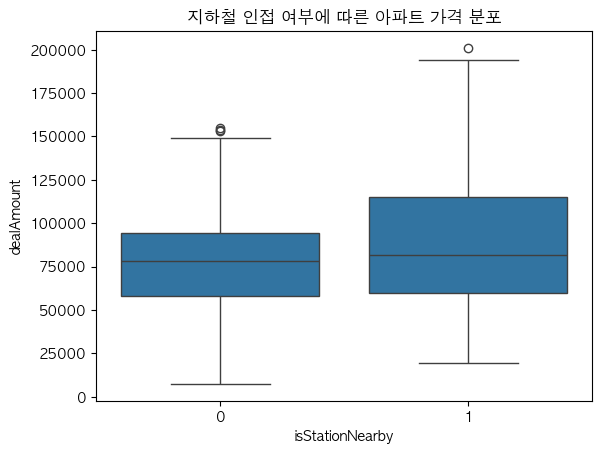

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# 박스플롯: 지하철 여부별 거래금액
sns.boxplot(x='isStationNearby', y='dealAmount', data=df)
plt.title('지하철 인접 여부에 따른 아파트 가격 분포')
plt.show()


In [69]:
# 지하철 여부별 평균, 중앙값
price_by_subway = df.groupby('isStationNearby')['dealAmount'].agg(['mean', 'median', 'count'])
print(price_by_subway)


                         mean   median  count
isStationNearby                              
0                80163.820809  78000.0    173
1                86933.828996  81500.0    269


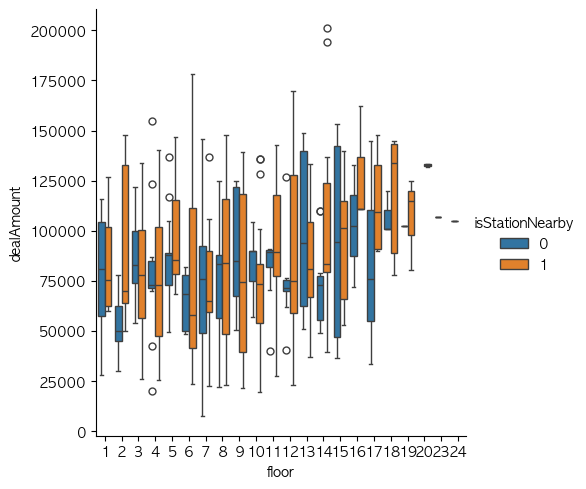

In [70]:
#지하철 여부 + 층수 = 가격 변화
sns.catplot(x='floor', y='dealAmount', hue='isStationNearby', data=df, kind='box')


<Axes: xlabel='area_bin', ylabel='dealAmount'>

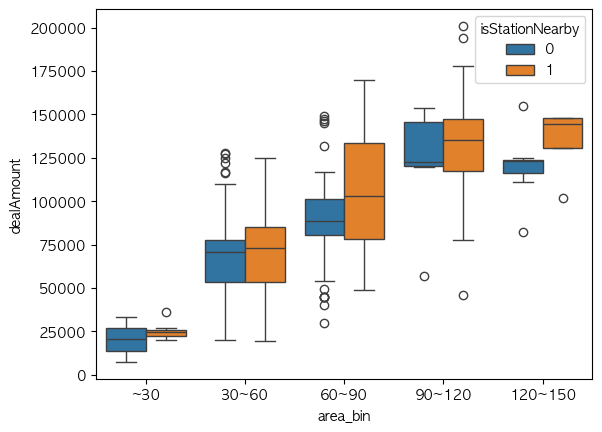

In [71]:
# 지하철 여부 + 전용면적 구간화
df['area_bin'] = pd.cut(df['excluUseAr'], bins=[0, 30, 60, 90, 120, 150], labels=['~30', '30~60', '60~90', '90~120', '120~150'])
sns.boxplot(x='area_bin', y='dealAmount', hue='isStationNearby', data=df)


In [72]:
features = ['excluUseAr', 'floor', 'buildingAge', 'umdNm',
            'isHighFloor', 'isStationNearby','subwayDistance']
train_compare_models(df, features)

LinearRegression → MAE: 14261.29, R²: 0.6836
RandomForest → MAE: 5825.90, R²: 0.8894
XGBoost → MAE: 5718.83, R²: 0.8741
LightGBM → MAE: 5427.50, R²: 0.8537


(              Model           MAE        R2
 0  LinearRegression  14261.290256  0.683622
 1      RandomForest   5825.902220  0.889424
 2           XGBoost   5718.834473  0.874082
 3          LightGBM   5427.497028  0.853706,
 {'LinearRegression': LinearRegression(),
  'RandomForest': RandomForestRegressor(random_state=42),
  'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_stra

In [73]:
df.dtypes

aptDong                    object
aptNm                      object
buildYear                   int64
buyerGbn                   object
cdealDay                   object
cdealType                  object
dealAmount                  int64
dealDay                     int64
dealMonth                   int64
dealYear                    int64
dealingGbn                 object
estateAgentSggNm           object
excluUseAr                float64
floor                       int64
jibun                      object
landLeaseholdGbn           object
rgstDate                   object
sggCd                       int64
slerGbn                    object
umdNm                      object
buildingAge                 int64
isHighFloor                 int64
dealYearMonth              object
dealQuarter                 int64
estateAgentSggNmClean      object
aptAddress                 object
aptLat                    float64
aptLng                    float64
subwayDistance              int64
isStationNearb

In [74]:
df_numeric = clean_numeric_df(df)
df_numeric.head(3)

,dealAmount,excluUseAr,floor,buildingAge,dealQuarter,isStationNearby,isHighFloor,subwayDistance
0,110000,85.00,14,22,1,0,0,839
1,56991,117.69,7,28,1,0,0,638
2,73000,49.50,4,33,1,1,0,433


In [75]:
# 상관관계 계산 전에 dealQuarter 제거
df_numeric = df_numeric.drop(columns = ['dealQuarter'])

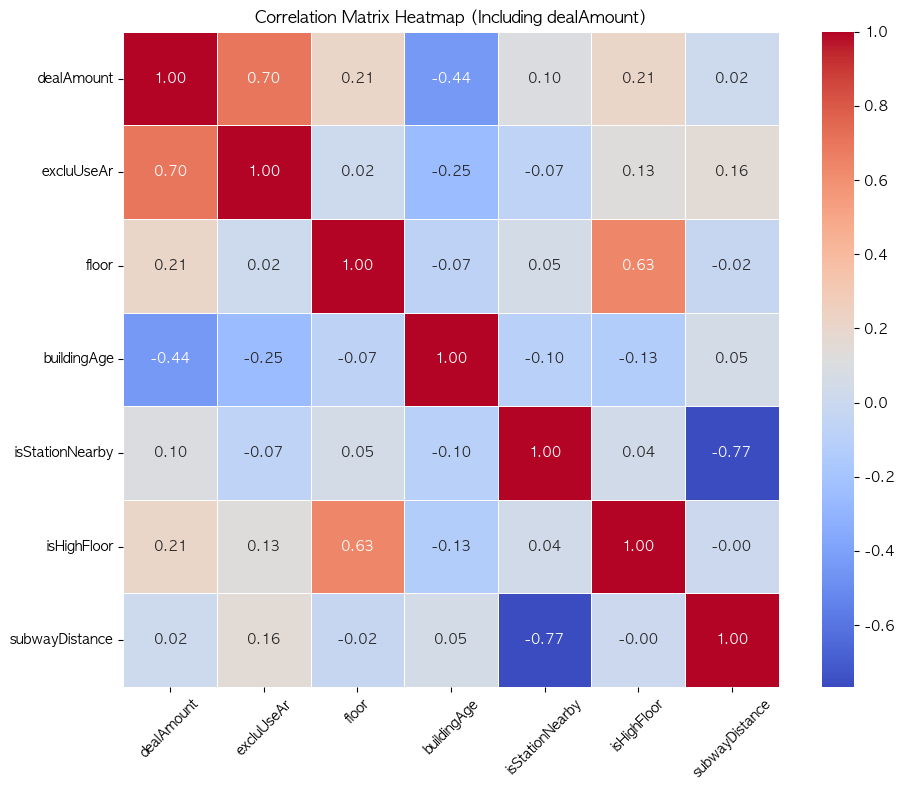

dealAmount         1.000000
excluUseAr         0.698213
floor              0.211017
isHighFloor        0.209703
isStationNearby    0.097283
subwayDistance     0.017685
buildingAge       -0.439943
Name: dealAmount, dtype: float64


In [76]:
plot_dealamount_correlation(df_numeric)

오히려 이전 지하철관련 추가를 안한 모델에서 더 좋은 MAE와 r2값이 나왔다. \
일단 역세권 여부에서 역세권인 집이 하나밖에 없어서 실거래 데이터를 더 많이 받아오는 방식으로 바꿔봐야겠다

지역을 강서구로 바꿔서 진행해 보았는데 전체적으로 R2값이 0.9까지는 아니지만 거의 0.9에 도달 \
하지만 df['subwayDistance']를 넣지 않고 df['isSationNearby']만 넣은 데이터에서는 조금 더 좋은 모델 성능이 나왔다. \
하지만 모델에서는 비교적 역세권이 집 값이 조금 더 높은 편이었다면 \
상관관계를 비교해 보았을 때는 역세권 여부에는 많은 영향을 미치지 않는 것으로 보인다. \
역세권 여부 컬럼을 넣었지만 변수 중요도는 높지 않았다. \
실거래 데이터만을 이용했을때 보다는 모델 성능이 더 좋게 나왔기 때문에 \
변수 중요도 외에 다른 컬럼들과의 관계성에서 유의미한 시너지를 보여주는 것 같다. \
이제 학군데이터를 추가해서 비교해볼 예정이다.


In [77]:
from base_model_utils import preprocess_base_df
df = preprocess_base_df(df)
df.to_csv('02_1_(distance)add_subway_df.csv', index=False)